In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openml
import scienceplots
import optuna

#plt.style.use('ggplot')
plt.style.use(['science', 'ieee', 'no-latex'])

#random_state
rs = 321

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Trabalho de Aprendizagem de Máquina II (PES Embraer)
Alunos: Caio Costa e Jonas Rodrigues

**Do Classroom:**

Seguem algumas instruções para realizar os experimentos:

- selecionar um banco de dados do OpenML (https://www.openml.org/)
    - o banco de dados de classificação deve ter: > 3 classes, >10 atributos e >1000 instâncias
- 10-fold cross-validation
- avaliar máquinas de aprendizagem: kNN, DT, MLP, NB e SVM
- métricas (area under the ROC curve, f1-score, accuracy, matriz de confusão média)
- opcional: para ajustar os parâmetros das máquinas de aprendizagem usar grid-search ou escolher os parâmetros e justificar
- avaliar estratégias de seleção de instâncias, seleção de atributos e/ou de balanceamento  

O relatório final deve conter pelo menos as seguintes informações:
1. Introdução  
2. Conceitos básicos  
    2.1. Técnicas de pré-processamento  
    2.2. Algoritmos de Aprendizagem de Máquina  
3. Metodologia dos Experimentos  
    3.1.Banco de dados  
    3.2.Métricas  
4. Resultados  
5. Conclusões  
6. Referências  

In [2]:
data = openml\
        .datasets\
        .get_dataset(46, download_data=True, download_qualities=True, download_features_meta_data=True)

df = data.get_data()[0]

Could not download file from http://openml1.win.tue.nl/dataset46/dataset_46.pq: Bucket does not exist or is private.
Failed to download parquet, fallback on ARFF.


In [3]:
data

OpenML Dataset
Name..........: splice
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:22:49
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/46/splice.arff
OpenML URL....: https://www.openml.org/d/46
# of features.: 61
# of instances: 3190

In [4]:
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,C,C,A,G,C,T,G,C,A,T,...,G,C,C,A,G,T,C,T,G,EI
1,A,G,A,C,C,C,G,C,C,G,...,T,G,C,C,C,C,C,G,C,EI
2,G,A,G,G,T,G,A,A,G,G,...,A,C,G,G,G,G,A,T,G,EI
3,G,G,G,C,T,G,C,G,T,T,...,G,T,T,T,T,C,C,C,C,EI
4,G,C,T,C,A,G,C,C,C,C,...,C,T,T,G,A,C,C,C,T,EI


In [5]:
#contagem das bases
cols = df.iloc[:,:-1]
cols.melt()['value'].value_counts()

value
C    50300
G    50245
T    46308
A    44487
N       56
D        2
R        1
S        1
Name: count, dtype: int64

In [6]:
#verificação de quantas instâncias possuem as bases ambíguas (N, D, R, S)

#instâncias que contém N, D, R ou S entre as features
idx_ndrs = df.iloc[:,:-1]\
             .isin(["N", "D", "R", "S"])\
             .any(axis=1) 

print(f"Existem {len(df[idx_ndrs])} linhas com bases ambíguas (N, D, R ou S).")

Existem 15 linhas com bases ambíguas (N, D, R ou S).


# Avaliação das classes target

In [7]:
df['Class'].value_counts()

Class
N     1655
IE     768
EI     767
Name: count, dtype: int64

<Axes: >

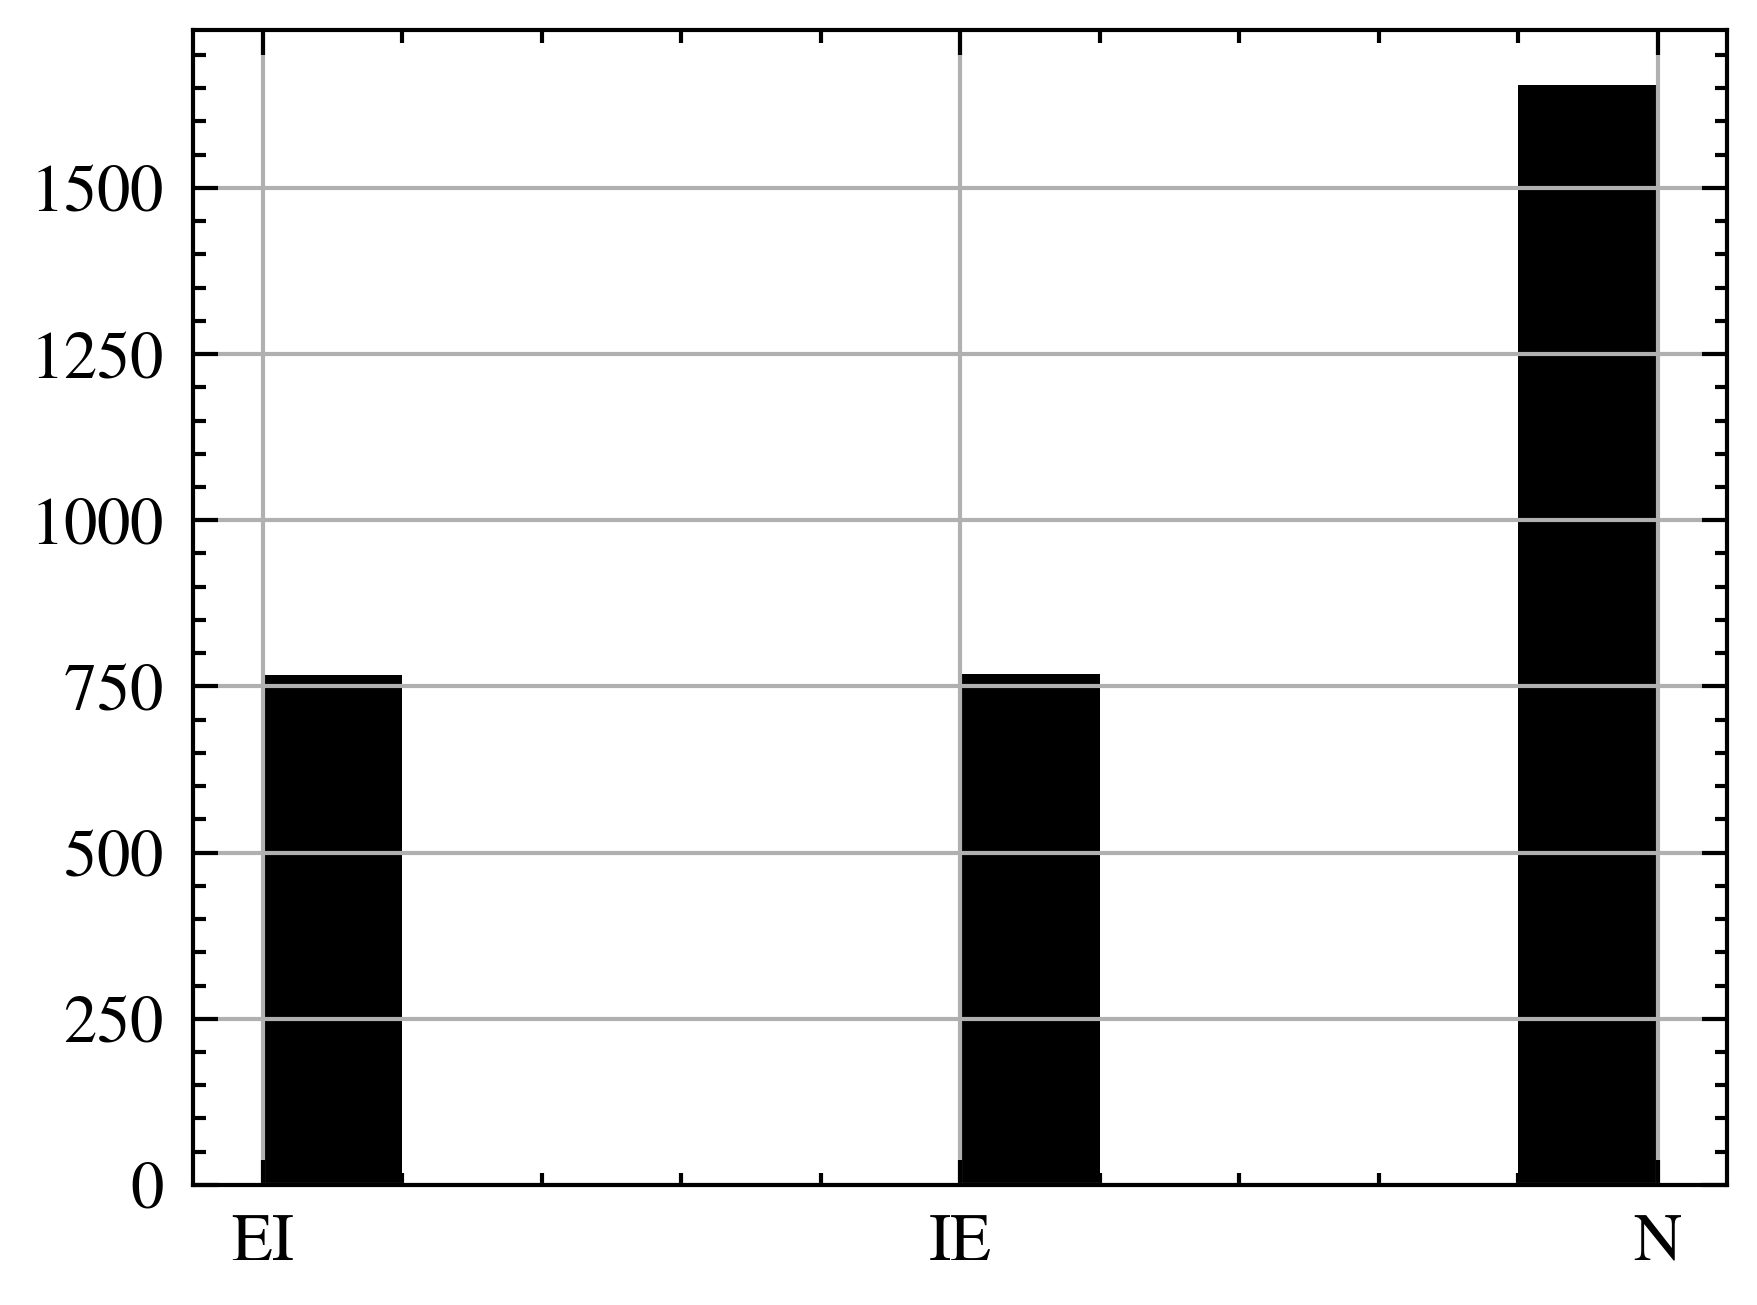

In [8]:
df['Class'].hist()

# Preparo do dataset

In [9]:
#remoção das instâncias com bases ambíguas

df = df[~idx_ndrs]

In [10]:
#converter colunas para categorical
for col in df.columns:
    df[col] = df[col].cat.remove_unused_categories()

# Encoding das features e targets

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

F = df.columns[:-1]
T = df.columns[-1]

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), F),
    ('oe', OrdinalEncoder(), [T]) #para este caso, LabelEncoder == OrdinalEncoder
])

In [12]:
encoded = ct.fit_transform(df).toarray()
encoded

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 2.],
       [1., 0., 0., ..., 0., 0., 2.],
       [1., 0., 0., ..., 0., 1., 2.]])

# Técnicas de pré-processamento
Nesta seção, criaremos as funções que pré-processam o dataset, para que possamos utilizar mais facilmente com GridSearchCV posteriormente.

In [13]:
#função para imprimir mudanças no tamanho do dataset

def size_diff(X_old, X_new):
    m_new, n_new = X_new.shape
    m_old, n_old = X_old.shape
    m_var = 100*(m_new - m_old)/m_old
    n_var = 100*(n_new - n_old)/n_old
    
    ans = "# Linhas: {} -> {} ({:.0f}%)\n# Colunas: {} -> {} ({:.0f}%)"\
          .format(m_old, m_new, m_var,
                  n_old, n_new, n_var)
    
    return ans

## Balanceamento de classes

### Undersampling da classe majoritária

In [14]:
from imblearn.under_sampling import RandomUnderSampler

def bal_undersampling(X_train, X_test, y_train, y_test):
    rus = RandomUnderSampler(random_state=rs)
    X_res, y_res = rus.fit_resample(X_train, y_train)
    return X_res, X_test, y_res, y_test    

### Synthetic Minority Oversampling Technique (SMOTE)

In [15]:
from imblearn.over_sampling import SMOTE

def bal_smote(X_train, X_test, y_train, y_test):
    smt = SMOTE(random_state=rs)
    X_smt, y_smt = smt.fit_resample(X_train, y_train)
    return X_smt, X_test, y_smt, y_test

## Redução de dimensionalidade

### Principal Component Analysis (PCA)

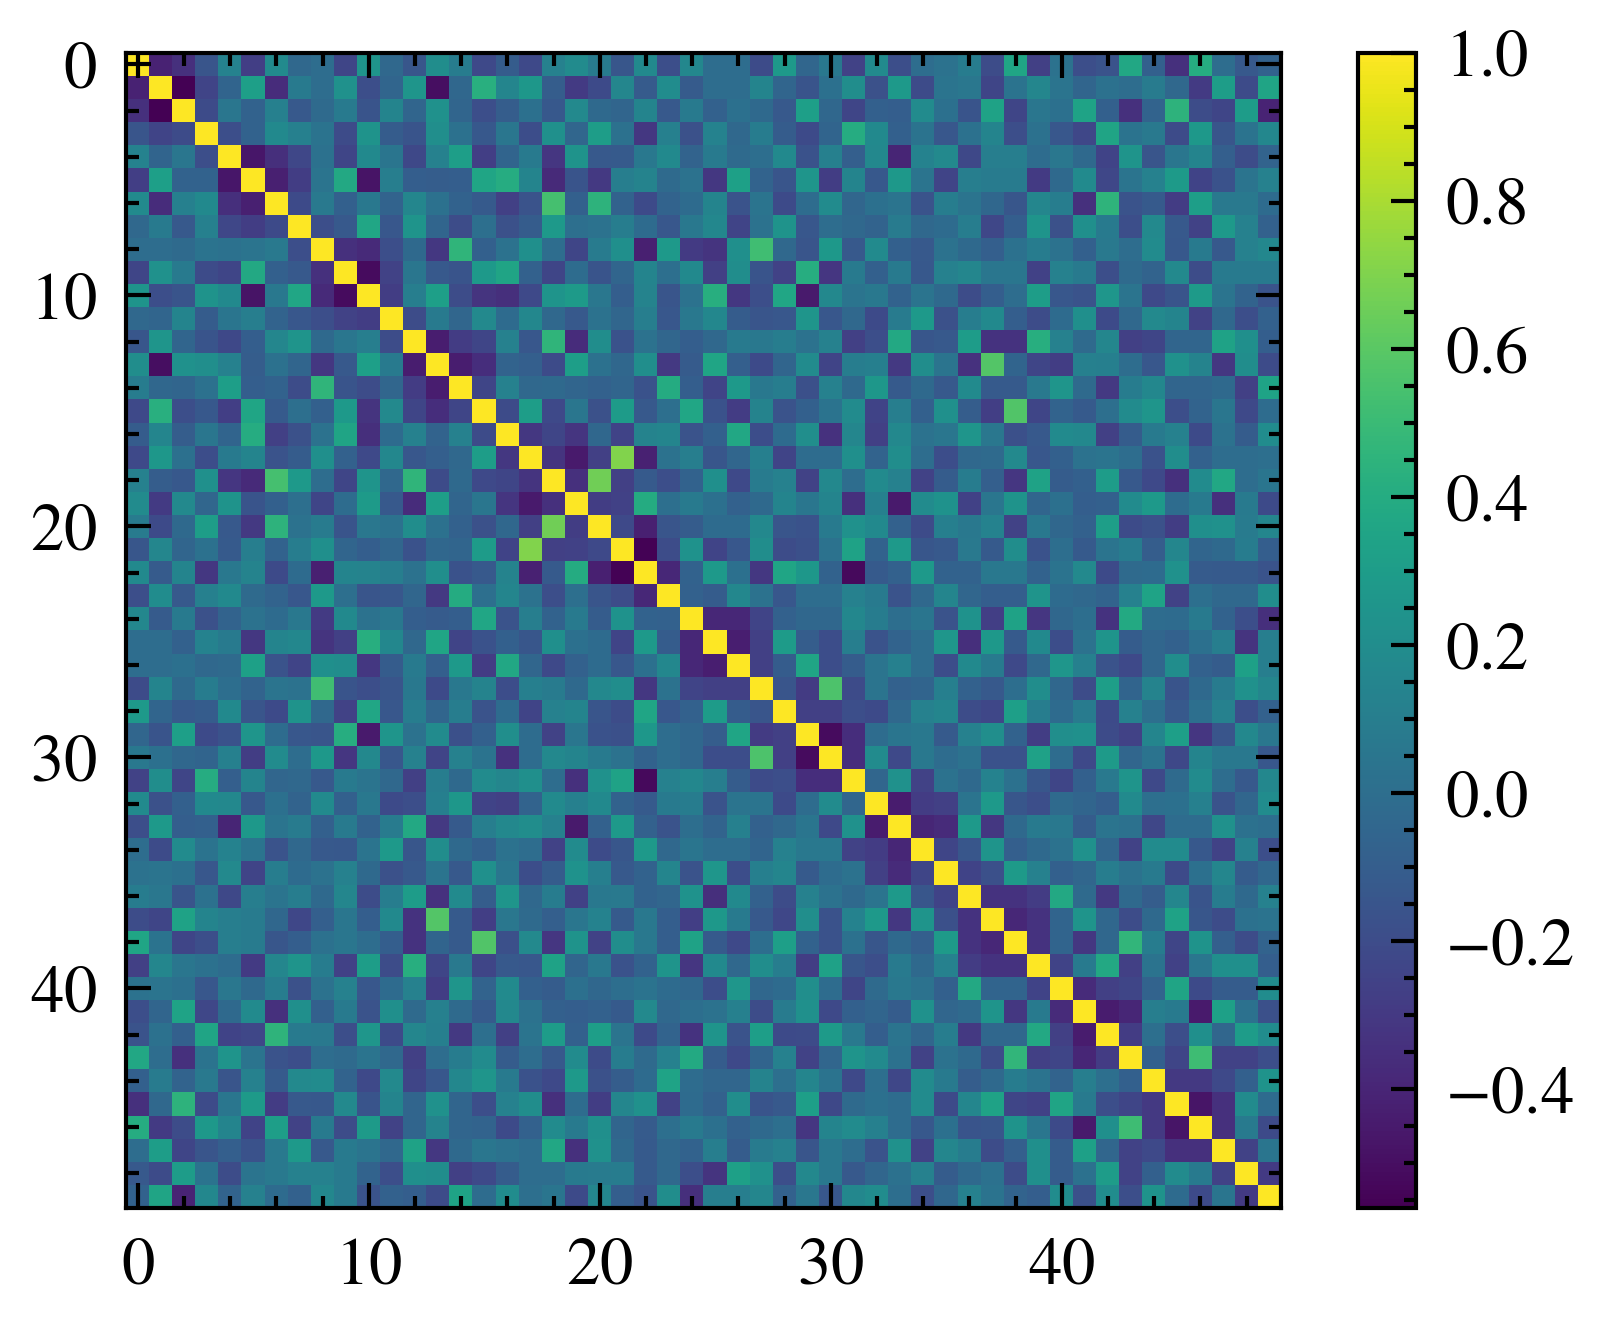

In [16]:
#PCA funciona melhor quando existem muitos atributos correlacionados

plt.imshow(np.corrcoef(encoded[:50, :50], rowvar=False))
plt.colorbar()

In [17]:
from sklearn.decomposition import PCA

def dr_pca(X_train, X_test, y_train, y_test, var=0.90):
    
    #a implementação do sklearn permite definir o número de componentes indiretamente
    #isto é, permite escolher o mínimo de variância que as componentes principais devem explicar
    
    pca = PCA(n_components = var)
    pca.fit(X_train)
    X_train_res = pca.transform(X_train)
    X_test_res = pca.transform(X_test)
    
    return X_train_res, X_test_res, y_train, y_test

**Observação:** Não usaremos Linear Discriminant Analysis (LDA) pois existem somente três classes no dataset, e por isso o número máximo de dimensões geradas seria somente $c-1 = 2$, uma redução muito acentuada com relação aos 240 atributos iniciais.

## Seleção de atributos
Usaremos os métodos de seleção de atributos Chi-Squared e Mutual Information por serem mais apropriados para variáveis de entrada e saída do tipo categórica.

### Chi-squared

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def as_chi2(X_train, X_test, y_train, y_test, return_model=False):
    k = int(X_train.shape[1]*0.61803398875) # Golden ratio
    
    min_cols = np.min(np.concatenate((X_train, X_test)), axis=0)
    min_cols = np.where(min_cols < 0, abs(min_cols), 0)
    X_train += min_cols
    X_test += min_cols
    
    fs = SelectKBest(score_func=chi2, k=k)
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    if(return_model):
        return X_train_fs, X_test_fs, y_train, y_test, fs
    
    return X_train_fs, X_test_fs, y_train, y_test

### Mutual information

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

def as_mutual_info(X_train, X_test, y_train, y_test, return_model=False):
    k = int(X_train.shape[1]*0.61803398875) # Golden ratio
    fs = SelectKBest(score_func=mutual_info_classif, k=k)
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    if(return_model):
        return X_train_fs, X_test_fs, y_train, y_test, fs
    
    return X_train_fs, X_test_fs, y_train, y_test

## Seleção de instâncias

### Edited Nearest Neighbors (ENN)

In [20]:
from imblearn.under_sampling import EditedNearestNeighbours

def ps_enn(X_train, X_test, y_train, y_test, n_neighbors=3):
    enn = EditedNearestNeighbours(n_neighbors=n_neighbors)
    X_res, y_res = enn.fit_resample(X_train, y_train)
    return X_res, X_test, y_res, y_test

### Condensed Nearest Neighbors (CNN)

In [21]:
from imblearn.under_sampling import CondensedNearestNeighbour

def ps_cnn(X_train, X_test, y_train, y_test, n_neighbors=3):
    cnn = CondensedNearestNeighbour(n_neighbors=n_neighbors)
    X_res, y_res = cnn.fit_resample(X_train, y_train)
    return X_res, X_test, y_res, y_test

# Divisão treino-teste
80% treino, 20% teste

In [22]:
from sklearn.model_selection import train_test_split

X = encoded[:, :-1]
y = encoded[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

print(f'X shape: ')
print(f'    Train = {X_train.shape}')
print(f'    Train = {X_test.shape}')
print(f'y shape: ')
print(f'    Train = {y_train.shape}')
print(f'    Test = {y_test.shape}')

X shape: 
    Train = (2540, 240)
    Train = (635, 240)
y shape: 
    Train = (2540,)
    Test = (635,)


Como vimos na análise anterior, nossa base de dados não é demasiadamente desbalanceada. Então optamos por não estratificar nesse caso.

In [23]:
pd.Series(y_train).value_counts(normalize=True)

2.0    0.516929
1.0    0.243307
0.0    0.239764
Name: proportion, dtype: float64

In [24]:
pd.Series(y_test).value_counts(normalize=True)

2.0    0.527559
0.0    0.240945
1.0    0.231496
Name: proportion, dtype: float64

Isso pode ser visto de maneira mais objetiva pelas células acima. É claro que temos uma proporção maior da classe do tipo 2, mas não de forma que acreditamos que seja consideravelmente superior às outras, o que poderia ser um indício de performance ruim dos algoritmos de aprendizado se simplesmente alimentássemos a eles os dados sem demais considerações.

# Preparação dos datasets pré-processados

In [25]:
dataset_labels = ['bal_undersampling', 'bal_smote', 'dr_pca', 'as_chi2', 'as_mutual_info', 'ps_enn', 'ps_cnn']
dataset_pre_proc_funcs = [bal_undersampling, bal_smote, dr_pca, as_chi2, as_mutual_info, ps_enn, ps_cnn]

assert(len(dataset_labels)==len(dataset_pre_proc_funcs))

In [26]:
dataset_labels_bal = ['bal_undersampling', 'bal_smote'] 
dataset_labels_red = ['dr_pca'] 
dataset_labels_atr = ['as_chi2', 'as_mutual_info']
dataset_labels_ins = ['ps_enn', 'ps_cnn']

dataset_pre_proc_funcs_bal = [bal_undersampling, bal_smote]
dataset_pre_proc_funcs_red = [dr_pca]
dataset_pre_proc_funcs_atr = [as_chi2, as_mutual_info] 
dataset_pre_proc_funcs_ins = [ps_enn, ps_cnn]

In [27]:
pp_datasets = {}
pp_datasets['original'] = (X_train, X_test, y_train, y_test)

for key, func in zip(dataset_labels, dataset_pre_proc_funcs):
    pp_datasets[key] = func(X_train, X_test, y_train, y_test)

In [28]:
for key_bal, func_bal in zip(dataset_labels_bal, dataset_pre_proc_funcs_bal):
    for key_red, func_red in zip(dataset_labels_red, dataset_pre_proc_funcs_red):
        for key_atr, func_atr in zip(dataset_labels_atr, dataset_pre_proc_funcs_atr):
            for key_ins, func_ins in zip(dataset_labels_ins, dataset_pre_proc_funcs_ins):
                key = key_bal + '_' + key_red + '_' + key_atr + '_' + key_ins
                func = lambda a, b, c, d : func_ins(*func_atr(*func_red(*func_bal(a, b, c, d))))
                pp_datasets[key] = func(X_train, X_test, y_train, y_test)

In [29]:
for key, value in pp_datasets.items():
    print(f"Dimension deltas for {key}:\n{size_diff(X_train, value[0])}\n")

Dimension deltas for original:
# Linhas: 2540 -> 2540 (0%)
# Colunas: 240 -> 240 (0%)

Dimension deltas for bal_undersampling:
# Linhas: 2540 -> 1827 (-28%)
# Colunas: 240 -> 240 (0%)

Dimension deltas for bal_smote:
# Linhas: 2540 -> 3939 (55%)
# Colunas: 240 -> 240 (0%)

Dimension deltas for dr_pca:
# Linhas: 2540 -> 2540 (0%)
# Colunas: 240 -> 145 (-40%)

Dimension deltas for as_chi2:
# Linhas: 2540 -> 2540 (0%)
# Colunas: 240 -> 148 (-38%)

Dimension deltas for as_mutual_info:
# Linhas: 2540 -> 2540 (0%)
# Colunas: 240 -> 148 (-38%)

Dimension deltas for ps_enn:
# Linhas: 2540 -> 1386 (-45%)
# Colunas: 240 -> 240 (0%)

Dimension deltas for ps_cnn:
# Linhas: 2540 -> 1472 (-42%)
# Colunas: 240 -> 240 (0%)

Dimension deltas for bal_undersampling_dr_pca_as_chi2_ps_enn:
# Linhas: 2540 -> 1205 (-53%)
# Colunas: 240 -> 86 (-64%)

Dimension deltas for bal_undersampling_dr_pca_as_chi2_ps_cnn:
# Linhas: 2540 -> 1137 (-55%)
# Colunas: 240 -> 86 (-64%)

Dimension deltas for bal_undersampling_d

In [30]:
len(pp_datasets)

16

# Classificadores e parâmetros para busca


Nesta seção e nas seguintes, exploraremos os seguintes algoritmos de aprendizado e seus hiperparâmetris:

- kNearest Neighbors (KNN);
- Decision Trees (DT);
- Multi-Layer Perceptron (MLP);
- Naive-Bayes (NB); 
- Support Vector Machines (SVM).

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve

In [32]:
estimators = {'knn': KNeighborsClassifier(), 
              'dt': DecisionTreeClassifier(),
              'mlp': MLPClassifier(),
              'nb': BernoulliNB(),
              'svm': SVC(probability=True)}

In [33]:
#listagem de hiperparâmetros

for a, b in estimators.items():
    print("Parâmetros padrões para {}: \n{}\n".format(b, b.get_params()))

Parâmetros padrões para KNeighborsClassifier(): 
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}

Parâmetros padrões para DecisionTreeClassifier(): 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Parâmetros padrões para MLPClassifier(): 
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation

In [34]:
# #parâmetros para busca (grid completa)

param_grid = {
    
    'knn': {
         'n_neighbors': optuna.distributions.IntDistribution(1, 128),
         'weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance']),
         'p': optuna.distributions.IntDistribution(1, 2)
     },
    
     'dt': {
         'criterion': optuna.distributions.CategoricalDistribution(["gini", "entropy", 'log_loss']),
         'splitter': optuna.distributions.CategoricalDistribution(['best', 'random']),
         'min_samples_leaf': optuna.distributions.IntDistribution(1, 3)
     },
    
     'mlp': {
             'hidden_layer_sizes': optuna.distributions.IntDistribution(1, 128, log=False),
             'activation': optuna.distributions.CategoricalDistribution(['logistic', 'tanh', 'relu']),
             'learning_rate_init': optuna.distributions.FloatDistribution(1e-10, 1e-1, log=True),
             'max_iter': optuna.distributions.CategoricalDistribution([100, 200, 500])
     },
    
     'nb': {
         'alpha': optuna.distributions.FloatDistribution(1e-10, 1e10, log=True),
         'fit_prior': optuna.distributions.CategoricalDistribution([True, False])
     },

     'svm': {
         'C': optuna.distributions.FloatDistribution(1e-10, 1e10, log=True),
         'kernel': optuna.distributions.CategoricalDistribution(['linear', 'rbf', 'poly']),
         'degree': optuna.distributions.IntDistribution(2, 3)
     }
}

# 10-fold stratified cross-validation

In [35]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)

# Baseline

In [36]:
from sklearn.dummy import DummyClassifier

dummy_clf_1 = DummyClassifier(strategy="most_frequent", random_state=rs).fit(X_train, y_train)
y_d1 = dummy_clf_1.predict(X_test)

dummy_clf_2 = DummyClassifier(strategy="stratified", random_state=rs).fit(X_train, y_train)
y_d2 = dummy_clf_2.predict(X_test)

In [37]:
print(f"Baseline de acurácia (prever o mais frequente) = {accuracy_score(y_d1, y_test)}")
print(f"Baseline de acurácia (prever aleatoriamente na mesma proporção) = {accuracy_score(y_d2, y_test)}")

Baseline de acurácia (prever o mais frequente) = 0.5275590551181102
Baseline de acurácia (prever aleatoriamente na mesma proporção) = 0.38110236220472443


In [38]:
print(f"Baseline de f1_score (prever o mais frequente) = {f1_score(y_d1, y_test, average='macro')}")
print(f"Baseline de f1_score (prever aleatoriamente na mesma proporção) = {f1_score(y_d2, y_test, average='macro')}")

Baseline de f1_score (prever o mais frequente) = 0.23024054982817868
Baseline de f1_score (prever aleatoriamente na mesma proporção) = 0.3326463258132321


**Não calcularemos uma baseline do score ROC AUC pois a definição é imprecisa para estes classificadores dummy:**
- Para o classificador "most_frequent", todas as predições são da mesma classe (a classe majoritária)
- Para o classificador "stratified", as probabilidades para cada instância são sempre da forma (0, 0, ..., 1, ..., 0, 0, 0), de modo que não faz sentido variar o limiar para calcular os vários pontos da curva ROC, mesmo usando One-vs-One ou One-vs-Rest.

# Grid Search CV

In [39]:
#função para gravar métricas de teste

def log_eval_metrics(actual, pred, pred_proba, prefix='test_'):
    
    f1 = f1_score(actual, pred, average='macro')
    acc = accuracy_score(actual, pred)
    roc_auc = roc_auc_score(actual, pred_proba, multi_class='ovr', average='macro') #'ovr' ou 'ovo'
    
    return f1, acc, roc_auc

In [40]:
from sklearn.metrics import accuracy_score, make_scorer

metrics = {"AUC": make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True),
           "Accuracy": make_scorer(accuracy_score),
           "F1-Score": make_scorer(f1_score, average='macro')}

In [41]:
assert(estimators.keys() == param_grid.keys())

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from itertools import product

#saídas dos GridSearchs
est_labels = []
dataset_labels = []
best_estimators = []
cv_results_train = []
results_test = []
conf_mats = []

for (est_name, est_est), (ds_name, ds_data) in product(estimators.items(), pp_datasets.items()):
    
    est_labels.append(est_name)
    dataset_labels.append(ds_name)
    
    X_train_, X_test_, y_train_, y_test_ = ds_data
    
    print(f"Executando {est_name} com dataset {ds_name}...")
    
    optuna_search = optuna.integration.OptunaSearchCV(
                        estimator = est_est,
                        param_distributions = param_grid[est_name],
                        scoring = make_scorer(f1_score, average='macro'),
                        cv = cv,
                        verbose=2,
                        n_jobs=-1,
                        refit=True)
    
    print(' Começou o fit')
    
    optuna_search.fit(X_train_, y_train_)
    
    print(' Armazenando dados de treinamento')

    best_est = optuna_search.best_estimator_
    cv_results_train.append(optuna_search.cv_results_)
    best_estimators.append(best_est)
    

    print(' Realizando predição')

    #predição
    y_pred = optuna_search.predict(X_test_)
    y_pred_proba = optuna_search.predict_proba(X_test_)
    
    print(' Armazenando matriz de confusão')

    conf_mats.append(confusion_matrix(y_test_, y_pred))

    print(' Armazenando métricas')
    
    results_test.append(log_eval_metrics(y_test_, y_pred, y_pred_proba))

    print(' Acabou')

/tmp/ipykernel_685397/4158558079.py:22: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-08-20 03:23:40,805] A new study created in memory with name: no-name-7686c3f3-39ef-4057-98d7-5628698008f7
[I 2023-08-20 03:23:40,806] Searching the best hyperparameters using 2540 samples...


Executando knn com dataset original...
 Começou o fit


[I 2023-08-20 03:23:42,430] Trial 0 finished with value: 0.7829068585495533 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.7829068585495533.
[I 2023-08-20 03:23:42,628] Trial 4 finished with value: 0.8625229589997186 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.8625229589997186.
[I 2023-08-20 03:23:42,652] Trial 9 finished with value: 0.8804318828921616 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'p': 2}. Best is trial 9 with value: 0.8804318828921616.
[I 2023-08-20 03:23:42,739] Trial 3 finished with value: 0.8728395129127675 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'p': 2}. Best is trial 9 with value: 0.8804318828921616.
[I 2023-08-20 03:23:42,932] Trial 1 finished with value: 0.8968668081283473 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.8968668081283473.
[I 2023-08-20 03:23:42,976] Trial 7 finish

 Armazenando dados de treinamento
 Realizando predição


/tmp/ipykernel_685397/4158558079.py:22: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-08-20 03:23:43,320] A new study created in memory with name: no-name-d25a6c6e-6728-47b8-b24a-05204edfaae4
[I 2023-08-20 03:23:43,321] Searching the best hyperparameters using 1827 samples...


 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset bal_undersampling...
 Começou o fit


[I 2023-08-20 03:23:44,462] Trial 8 finished with value: 0.7153687489095297 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'p': 2}. Best is trial 8 with value: 0.7153687489095297.
[I 2023-08-20 03:23:44,575] Trial 1 finished with value: 0.7221373676481816 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.7221373676481816.
[I 2023-08-20 03:23:44,637] Trial 3 finished with value: 0.7202394694921607 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.7221373676481816.
[I 2023-08-20 03:23:44,660] Trial 9 finished with value: 0.7139507752765882 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.7221373676481816.
[I 2023-08-20 03:23:44,671] Trial 0 finished with value: 0.7066591814356298 and parameters: {'n_neighbors': 85, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.7221373676481816.
[I 2023-08-20 03:23:44,719] Trial 5 fini

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset bal_smote...
 Começou o fit


[I 2023-08-20 03:23:47,444] Trial 9 finished with value: 0.5301719588335223 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 2}. Best is trial 9 with value: 0.5301719588335223.
[I 2023-08-20 03:23:47,938] Trial 5 finished with value: 0.5315310465380619 and parameters: {'n_neighbors': 54, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.5315310465380619.
[I 2023-08-20 03:23:48,098] Trial 2 finished with value: 0.5313756432827031 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.5315310465380619.
[I 2023-08-20 03:23:48,490] Trial 0 finished with value: 0.5259711657263121 and parameters: {'n_neighbors': 74, 'weights': 'uniform', 'p': 2}. Best is trial 5 with value: 0.5315310465380619.
[I 2023-08-20 03:23:48,581] Trial 4 finished with value: 0.525520824604629 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'p': 2}. Best is trial 5 with value: 0.5315310465380619.
[I 2023-08-20 03:23:48,975] Trial 1 finishe

 Armazenando dados de treinamento
 Realizando predição


/tmp/ipykernel_685397/4158558079.py:22: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-08-20 03:23:49,634] A new study created in memory with name: no-name-b44993be-ada8-4edf-b1f9-84461101ae36
[I 2023-08-20 03:23:49,635] Searching the best hyperparameters using 2540 samples...


 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset dr_pca...
 Começou o fit


[I 2023-08-20 03:23:51,081] Trial 4 finished with value: 0.8437968442500354 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 1}. Best is trial 4 with value: 0.8437968442500354.
[I 2023-08-20 03:23:51,275] Trial 5 finished with value: 0.9268652170144378 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.9268652170144378.
[I 2023-08-20 03:23:51,289] Trial 8 finished with value: 0.8571179869814219 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.9268652170144378.
[I 2023-08-20 03:23:51,356] Trial 0 finished with value: 0.8730309717650326 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'p': 1}. Best is trial 5 with value: 0.9268652170144378.
[I 2023-08-20 03:23:51,392] Trial 6 finished with value: 0.9302220248267034 and parameters: {'n_neighbors': 52, 'weights': 'uniform', 'p': 2}. Best is trial 6 with value: 0.9302220248267034.
[I 2023-08-20 03:23:51,404] Trial 9 finishe

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset as_chi2...
 Começou o fit


[I 2023-08-20 03:23:52,978] Trial 5 finished with value: 0.7779511285993833 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.7779511285993833.
[I 2023-08-20 03:23:53,189] Trial 3 finished with value: 0.8657555454917283 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.8657555454917283.
[I 2023-08-20 03:23:53,254] Trial 2 finished with value: 0.8223440768948563 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.8657555454917283.
[I 2023-08-20 03:23:53,301] Trial 4 finished with value: 0.8673223344658576 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.8673223344658576.
[I 2023-08-20 03:23:53,497] Trial 6 finished with value: 0.8657698944189777 and parameters: {'n_neighbors': 59, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.8673223344658576.
[I 2023-08-20 03:23:53,516] Trial 8 finishe

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset as_mutual_info...
 Começou o fit


[I 2023-08-20 03:23:55,481] Trial 6 finished with value: 0.7920520012432163 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 1}. Best is trial 6 with value: 0.7920520012432163.
[I 2023-08-20 03:23:55,519] Trial 3 finished with value: 0.8629672268129843 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.8629672268129843.
[I 2023-08-20 03:23:55,676] Trial 7 finished with value: 0.843567656156346 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.8629672268129843.
[I 2023-08-20 03:23:55,681] Trial 9 finished with value: 0.8509038122167276 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.8629672268129843.
[I 2023-08-20 03:23:55,697] Trial 8 finished with value: 0.8652417531751032 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'p': 2}. Best is trial 8 with value: 0.8652417531751032.
[I 2023-08-20 03:23:55,755] Trial 4 finished 

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset ps_enn...
 Começou o fit


[I 2023-08-20 03:23:56,931] Trial 4 finished with value: 0.7813356743390699 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 1}. Best is trial 4 with value: 0.7813356743390699.
[I 2023-08-20 03:23:56,932] Trial 8 finished with value: 0.8827390874420005 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 0.8827390874420005.
[I 2023-08-20 03:23:57,015] Trial 0 finished with value: 0.757842759550558 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'p': 1}. Best is trial 8 with value: 0.8827390874420005.
[I 2023-08-20 03:23:57,021] Trial 7 finished with value: 0.7734948440683241 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 1}. Best is trial 8 with value: 0.8827390874420005.
[I 2023-08-20 03:23:57,114] Trial 3 finished with value: 0.7396648506400958 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'p': 1}. Best is trial 8 with value: 0.8827390874420005.
[I 2023-08-20 03:23:57,118] Trial 1 finished w

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset ps_cnn...
 Começou o fit


[I 2023-08-20 03:23:58,314] Trial 6 finished with value: 0.5852018886442155 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 6 with value: 0.5852018886442155.
[I 2023-08-20 03:23:58,319] Trial 4 finished with value: 0.5399689521497036 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 6 with value: 0.5852018886442155.
[I 2023-08-20 03:23:58,443] Trial 8 finished with value: 0.6154246308681403 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'p': 1}. Best is trial 8 with value: 0.6154246308681403.
[I 2023-08-20 03:23:58,453] Trial 1 finished with value: 0.5848958126859349 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 0.6154246308681403.
[I 2023-08-20 03:23:58,461] Trial 9 finished with value: 0.6342779323617822 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 2}. Best is trial 9 with value: 0.6342779323617822.
[I 2023-08-20 03:23:58,537] Trial 3 finished 

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset bal_undersampling_dr_pca_as_chi2_ps_enn...
 Começou o fit


[I 2023-08-20 03:23:59,279] Trial 7 finished with value: 0.8682805973064376 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 0.8682805973064376.
[I 2023-08-20 03:23:59,348] Trial 0 finished with value: 0.9276317874407047 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.9276317874407047.
[I 2023-08-20 03:23:59,394] Trial 9 finished with value: 0.8819696758426984 and parameters: {'n_neighbors': 61, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.9276317874407047.
[I 2023-08-20 03:23:59,421] Trial 3 finished with value: 0.8779095434064909 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9276317874407047.
[I 2023-08-20 03:23:59,448] Trial 4 finished with value: 0.9188643001502976 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9276317874407047.
[I 2023-08-20 03:23:59,454] Trial 1 finished 

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset bal_undersampling_dr_pca_as_chi2_ps_cnn...
 Começou o fit


[I 2023-08-20 03:24:00,160] Trial 1 finished with value: 0.5118472802189853 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.5118472802189853.
[I 2023-08-20 03:24:00,187] Trial 3 finished with value: 0.6673698748951647 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.6673698748951647.
[I 2023-08-20 03:24:00,222] Trial 2 finished with value: 0.428588553070924 and parameters: {'n_neighbors': 57, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.6673698748951647.
[I 2023-08-20 03:24:00,283] Trial 8 finished with value: 0.42414680258531084 and parameters: {'n_neighbors': 56, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.6673698748951647.
[I 2023-08-20 03:24:00,350] Trial 5 finished with value: 0.5024035343030964 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.6673698748951647.
[I 2023-08-20 03:24:00,355] Trial 0 finished

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset bal_undersampling_dr_pca_as_mutual_info_ps_enn...
 Começou o fit


[I 2023-08-20 03:24:00,977] Trial 2 finished with value: 0.7441900784168458 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.7441900784168458.
[I 2023-08-20 03:24:01,010] Trial 0 finished with value: 0.7566258667015276 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.7566258667015276.
[I 2023-08-20 03:24:01,134] Trial 3 finished with value: 0.839374991544281 and parameters: {'n_neighbors': 60, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.839374991544281.
[I 2023-08-20 03:24:01,205] Trial 8 finished with value: 0.8304824206340969 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.839374991544281.
[I 2023-08-20 03:24:01,230] Trial 6 finished with value: 0.7960017244721962 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.839374991544281.
[I 2023-08-20 03:24:01,241] Trial 5 finished with

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset bal_undersampling_dr_pca_as_mutual_info_ps_cnn...
 Começou o fit


[I 2023-08-20 03:24:01,859] Trial 7 finished with value: 0.6352247578302973 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 2}. Best is trial 7 with value: 0.6352247578302973.
[I 2023-08-20 03:24:01,900] Trial 4 finished with value: 0.6834990249031074 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.6834990249031074.
[I 2023-08-20 03:24:01,989] Trial 2 finished with value: 0.702182615687248 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.702182615687248.
[I 2023-08-20 03:24:02,013] Trial 1 finished with value: 0.5517455632280915 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.702182615687248.
[I 2023-08-20 03:24:02,024] Trial 5 finished with value: 0.7190738550131603 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.7190738550131603.
[I 2023-08-20 03:24:02,055] Trial 8 finished w

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset bal_smote_dr_pca_as_chi2_ps_enn...
 Começou o fit


[I 2023-08-20 03:24:04,013] Trial 7 finished with value: 0.6427771130846873 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 0.6427771130846873.
[I 2023-08-20 03:24:04,021] Trial 1 finished with value: 0.7498387839627346 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.7498387839627346.
[I 2023-08-20 03:24:04,047] Trial 4 finished with value: 0.7329060149410483 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.7498387839627346.
[I 2023-08-20 03:24:04,088] Trial 8 finished with value: 0.7166135575043959 and parameters: {'n_neighbors': 57, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.7498387839627346.
[I 2023-08-20 03:24:04,139] Trial 6 finished with value: 0.763120253088552 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 0.763120253088552.
[I 2023-08-20 03:24:04,148] Trial 5 finished 

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset bal_smote_dr_pca_as_chi2_ps_cnn...
 Começou o fit


[I 2023-08-20 03:24:05,481] Trial 3 finished with value: 0.49753457197665246 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.49753457197665246.
[I 2023-08-20 03:24:05,673] Trial 4 finished with value: 0.27416572338117745 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.49753457197665246.
[I 2023-08-20 03:24:05,850] Trial 1 finished with value: 0.4228304081772193 and parameters: {'n_neighbors': 102, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.49753457197665246.
[I 2023-08-20 03:24:05,918] Trial 2 finished with value: 0.2622508569038181 and parameters: {'n_neighbors': 71, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.49753457197665246.
[I 2023-08-20 03:24:05,968] Trial 7 finished with value: 0.2941188080272173 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.49753457197665246.
[I 2023-08-20 03:24:06,031] Trial 6

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset bal_smote_dr_pca_as_mutual_info_ps_enn...
 Começou o fit


[I 2023-08-20 03:24:07,552] Trial 0 finished with value: 0.6418740697960422 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.6418740697960422.
[I 2023-08-20 03:24:07,821] Trial 4 finished with value: 0.6620886829163114 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.6620886829163114.
[I 2023-08-20 03:24:07,911] Trial 2 finished with value: 0.6525794996629333 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.6620886829163114.
[I 2023-08-20 03:24:07,925] Trial 6 finished with value: 0.6397572624641228 and parameters: {'n_neighbors': 69, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.6620886829163114.
[I 2023-08-20 03:24:08,026] Trial 8 finished with value: 0.6461441908528969 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.6620886829163114.
[I 2023-08-20 03:24:08,073] Trial 3 finishe

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando knn com dataset bal_smote_dr_pca_as_mutual_info_ps_cnn...
 Começou o fit


[I 2023-08-20 03:24:09,649] Trial 0 finished with value: 0.38958039389261606 and parameters: {'n_neighbors': 51, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.38958039389261606.
[I 2023-08-20 03:24:09,844] Trial 2 finished with value: 0.23496692100595254 and parameters: {'n_neighbors': 68, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.38958039389261606.
[I 2023-08-20 03:24:09,852] Trial 6 finished with value: 0.28614638922275065 and parameters: {'n_neighbors': 57, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.38958039389261606.
[I 2023-08-20 03:24:09,858] Trial 9 finished with value: 0.33949459420888695 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.38958039389261606.
[I 2023-08-20 03:24:09,860] Trial 3 finished with value: 0.3682201800030976 and parameters: {'n_neighbors': 127, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.38958039389261606.
[I 2023-08-20 03:24:09,865] Tria

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset original...
 Começou o fit


[I 2023-08-20 03:24:11,424] Trial 2 finished with value: 0.9240633099169084 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9240633099169084.
[I 2023-08-20 03:24:11,438] Trial 5 finished with value: 0.9217523040320543 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9240633099169084.
[I 2023-08-20 03:24:11,452] Trial 6 finished with value: 0.9263640902128992 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 3}. Best is trial 6 with value: 0.9263640902128992.
[I 2023-08-20 03:24:11,463] Trial 4 finished with value: 0.9249640727128572 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 6 with value: 0.9263640902128992.
[I 2023-08-20 03:24:11,479] Trial 3 finished with value: 0.925780334883482 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 1}. Best 

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset bal_undersampling...
 Começou o fit


[I 2023-08-20 03:24:12,340] Trial 4 finished with value: 0.9136732803238026 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9136732803238026.
[I 2023-08-20 03:24:12,361] Trial 3 finished with value: 0.9228348151972325 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9228348151972325.
[I 2023-08-20 03:24:12,369] Trial 6 finished with value: 0.9250273885095419 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 2}. Best is trial 6 with value: 0.9250273885095419.
[I 2023-08-20 03:24:12,378] Trial 2 finished with value: 0.9244516545515251 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 6 with value: 0.9250273885095419.
[I 2023-08-20 03:24:12,386] Trial 7 finished with value: 0.9222214325383659 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'min_samples_leaf': 1}.

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset bal_smote...
 Começou o fit


[I 2023-08-20 03:24:14,893] Trial 7 finished with value: 0.9534934800989989 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 7 with value: 0.9534934800989989.
[I 2023-08-20 03:24:14,916] Trial 2 finished with value: 0.953498833749493 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 2 with value: 0.953498833749493.
[I 2023-08-20 03:24:14,992] Trial 4 finished with value: 0.9499970596344692 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 2 with value: 0.953498833749493.
[I 2023-08-20 03:24:15,004] Trial 8 finished with value: 0.9555417714572851 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 8 with value: 0.9555417714572851.
[I 2023-08-20 03:24:15,459] Trial 0 finished with value: 0.9509874165023845 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 2}. Bes

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset dr_pca...
 Começou o fit


[I 2023-08-20 03:24:16,369] Trial 7 finished with value: 0.8589866002425837 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 7 with value: 0.8589866002425837.
[I 2023-08-20 03:24:16,397] Trial 9 finished with value: 0.8668790635527186 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 9 with value: 0.8668790635527186.
[I 2023-08-20 03:24:16,402] Trial 4 finished with value: 0.8649295022689876 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 9 with value: 0.8668790635527186.
[I 2023-08-20 03:24:16,415] Trial 0 finished with value: 0.8664077578703504 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 9 with value: 0.8668790635527186.
[I 2023-08-20 03:24:16,438] Trial 6 finished with value: 0.852538227323884 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset as_chi2...
 Começou o fit


[I 2023-08-20 03:24:20,040] Trial 0 finished with value: 0.9290546510315248 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9290546510315248.
[I 2023-08-20 03:24:20,054] Trial 9 finished with value: 0.9228969025922028 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9290546510315248.
[I 2023-08-20 03:24:20,065] Trial 3 finished with value: 0.9224635896223387 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9290546510315248.
[I 2023-08-20 03:24:20,075] Trial 5 finished with value: 0.9197953270665137 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9290546510315248.
[I 2023-08-20 03:24:20,088] Trial 4 finished with value: 0.9160606228477025 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 1}. Best is tria

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset as_mutual_info...
 Começou o fit


[I 2023-08-20 03:24:20,830] Trial 8 finished with value: 0.9256384889565424 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 3}. Best is trial 8 with value: 0.9256384889565424.
[I 2023-08-20 03:24:20,840] Trial 1 finished with value: 0.9216501905535267 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 2}. Best is trial 8 with value: 0.9256384889565424.
[I 2023-08-20 03:24:20,847] Trial 6 finished with value: 0.92184717662801 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 3}. Best is trial 8 with value: 0.9256384889565424.
[I 2023-08-20 03:24:20,854] Trial 3 finished with value: 0.924845957711406 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'min_samples_leaf': 3}. Best is trial 8 with value: 0.9256384889565424.
[I 2023-08-20 03:24:20,865] Trial 5 finished with value: 0.9246273005994142 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 3}. Best is trial 

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset ps_enn...
 Começou o fit


[I 2023-08-20 03:24:21,503] Trial 2 finished with value: 0.953983874146074 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 2}. Best is trial 2 with value: 0.953983874146074.
[I 2023-08-20 03:24:21,505] Trial 7 finished with value: 0.9493713625059602 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'min_samples_leaf': 1}. Best is trial 2 with value: 0.953983874146074.
[I 2023-08-20 03:24:21,514] Trial 0 finished with value: 0.9540310848819894 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9540310848819894.
[I 2023-08-20 03:24:21,522] Trial 1 finished with value: 0.9556810962498028 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9556810962498028.
[I 2023-08-20 03:24:21,535] Trial 3 finished with value: 0.9548790637733331 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 2}. Best is t

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset ps_cnn...
 Começou o fit


[I 2023-08-20 03:24:22,154] Trial 0 finished with value: 0.8882036096562229 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8882036096562229.
[I 2023-08-20 03:24:22,196] Trial 1 finished with value: 0.8811237090966326 and parameters: {'criterion': 'gini', 'splitter': 'best', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8882036096562229.
[I 2023-08-20 03:24:22,214] Trial 8 finished with value: 0.8889537242560062 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 8 with value: 0.8889537242560062.
[I 2023-08-20 03:24:22,224] Trial 5 finished with value: 0.8874825088998086 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 8 with value: 0.8889537242560062.
[I 2023-08-20 03:24:22,229] Trial 2 finished with value: 0.886627166110034 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'min_samples_leaf': 3}. Best is t

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset bal_undersampling_dr_pca_as_chi2_ps_enn...
 Começou o fit


[I 2023-08-20 03:24:22,564] Trial 4 finished with value: 0.9056539235927357 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9056539235927357.
[I 2023-08-20 03:24:22,578] Trial 9 finished with value: 0.9023388047485584 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9056539235927357.
[I 2023-08-20 03:24:22,596] Trial 5 finished with value: 0.9007910320738353 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9056539235927357.
[I 2023-08-20 03:24:22,601] Trial 3 finished with value: 0.9084304979062333 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9084304979062333.
[I 2023-08-20 03:24:22,607] Trial 8 finished with value: 0.914446609084659 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 1}

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset bal_undersampling_dr_pca_as_chi2_ps_cnn...
 Começou o fit


[I 2023-08-20 03:24:23,461] Trial 5 finished with value: 0.8006371472805028 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 5 with value: 0.8006371472805028.
[I 2023-08-20 03:24:23,481] Trial 1 finished with value: 0.7823100269152862 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8006371472805028.
[I 2023-08-20 03:24:23,502] Trial 7 finished with value: 0.7847559405908905 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 5 with value: 0.8006371472805028.
[I 2023-08-20 03:24:23,505] Trial 0 finished with value: 0.8053566301598554 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8053566301598554.
[I 2023-08-20 03:24:23,513] Trial 9 finished with value: 0.7850615838398128 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 1}. B

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset bal_undersampling_dr_pca_as_mutual_info_ps_enn...
 Começou o fit


[I 2023-08-20 03:24:24,305] Trial 0 finished with value: 0.8894803868894623 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8894803868894623.
[I 2023-08-20 03:24:24,312] Trial 3 finished with value: 0.9015295846098386 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9015295846098386.
[I 2023-08-20 03:24:24,318] Trial 9 finished with value: 0.8859927357871296 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9015295846098386.
[I 2023-08-20 03:24:24,335] Trial 5 finished with value: 0.8839052587251187 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9015295846098386.
[I 2023-08-20 03:24:24,826] Trial 1 finished with value: 0.9204921526460019 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'min_samples_leaf':

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset bal_undersampling_dr_pca_as_mutual_info_ps_cnn...
 Começou o fit


[I 2023-08-20 03:24:25,330] Trial 7 finished with value: 0.760234393983207 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 7 with value: 0.760234393983207.
[I 2023-08-20 03:24:25,337] Trial 9 finished with value: 0.7800331132042249 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 9 with value: 0.7800331132042249.
[I 2023-08-20 03:24:25,348] Trial 6 finished with value: 0.7695340061442988 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 9 with value: 0.7800331132042249.
[I 2023-08-20 03:24:25,358] Trial 5 finished with value: 0.7858415719842953 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 5 with value: 0.7858415719842953.
[I 2023-08-20 03:24:25,365] Trial 3 finished with value: 0.7527813320724608 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset bal_smote_dr_pca_as_chi2_ps_enn...
 Começou o fit


[I 2023-08-20 03:24:26,260] Trial 4 finished with value: 0.9308993489909424 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9308993489909424.
[I 2023-08-20 03:24:26,268] Trial 2 finished with value: 0.9190081894191444 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9308993489909424.
[I 2023-08-20 03:24:26,274] Trial 9 finished with value: 0.9280599875733943 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9308993489909424.
[I 2023-08-20 03:24:26,282] Trial 1 finished with value: 0.9314634745294399 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9314634745294399.
[I 2023-08-20 03:24:27,845] Trial 8 finished with value: 0.9407144256158435 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'min_samples_leaf': 1}. Bes

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset bal_smote_dr_pca_as_chi2_ps_cnn...
 Começou o fit


[I 2023-08-20 03:24:29,079] Trial 5 finished with value: 0.8400108292797339 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 5 with value: 0.8400108292797339.
[I 2023-08-20 03:24:29,088] Trial 0 finished with value: 0.8487434131324395 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8487434131324395.
[I 2023-08-20 03:24:29,099] Trial 4 finished with value: 0.8447376450732763 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8487434131324395.
[I 2023-08-20 03:24:29,118] Trial 1 finished with value: 0.8456902224895986 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8487434131324395.
[I 2023-08-20 03:24:29,128] Trial 7 finished with value: 0.847273440090845 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf':

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset bal_smote_dr_pca_as_mutual_info_ps_enn...
 Começou o fit


[I 2023-08-20 03:24:31,577] Trial 1 finished with value: 0.9325341559245356 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9325341559245356.
[I 2023-08-20 03:24:31,578] Trial 6 finished with value: 0.9300239741791104 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9325341559245356.
[I 2023-08-20 03:24:31,584] Trial 8 finished with value: 0.9283533710045695 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9325341559245356.
[I 2023-08-20 03:24:31,590] Trial 2 finished with value: 0.9328377793559864 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9328377793559864.
[I 2023-08-20 03:24:31,600] Trial 3 finished with value: 0.9441443555867629 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf'

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando dt com dataset bal_smote_dr_pca_as_mutual_info_ps_cnn...
 Começou o fit


[I 2023-08-20 03:24:33,301] Trial 8 finished with value: 0.8574352408902198 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 8 with value: 0.8574352408902198.
[I 2023-08-20 03:24:33,304] Trial 4 finished with value: 0.8408537493789648 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 8 with value: 0.8574352408902198.
[I 2023-08-20 03:24:33,323] Trial 2 finished with value: 0.8352443727399894 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'min_samples_leaf': 2}. Best is trial 8 with value: 0.8574352408902198.
[I 2023-08-20 03:24:33,345] Trial 3 finished with value: 0.848722422841744 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 1}. Best is trial 8 with value: 0.8574352408902198.
[I 2023-08-20 03:24:33,350] Trial 0 finished with value: 0.8431722888971246 and parameters: {'criterion': 'gini', 'splitter': 'random', 'min_samples_leaf': 1}. 

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset original...
 Começou o fit


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:24:49,613] Trial 8 finished with value: 0.30121095032470346 and parameters: {'hidden_layer_sizes': 15, 'activation': 'tanh', 'learning_rate_init': 1.0733678327319002e-10, 'max_iter': 500}. Best is trial 8 with value: 0.30121095032470346.
[I 2023-08-20 03:24:51,000] Trial 2 finished with value: 0.2937541919447343 and parameters: {'hidden_layer_sizes': 26, 'activation': 'tanh', 'learning_rate_init': 1.4303171644628346e-10, 'max_iter': 500}. Best is trial 8 with value: 0.30121095032470346.
/home/jonas

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset bal_undersampling...
 Começou o fit


[I 2023-08-20 03:26:02,842] Trial 1 finished with value: 0.23798201359734703 and parameters: {'hidden_layer_sizes': 13, 'activation': 'relu', 'learning_rate_init': 9.523967699291388e-10, 'max_iter': 100}. Best is trial 1 with value: 0.23798201359734703.
[I 2023-08-20 03:26:04,521] Trial 6 finished with value: 0.16843029972214488 and parameters: {'hidden_layer_sizes': 25, 'activation': 'logistic', 'learning_rate_init': 2.565192410757793e-07, 'max_iter': 200}. Best is trial 1 with value: 0.23798201359734703.
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:26:04,948] Trial 9 finished with value: 0.1734055176297483 and parameters: {'hidden_layer_sizes': 32, 'activation': 'logistic', 'learning_rate_init': 2.655912443766894e-10, 'max_iter': 200}. Best is trial 1 with value: 0.2379820135

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset bal_smote...
 Começou o fit


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:27:36,892] Trial 8 finished with value: 0.25614124410904376 and parameters: {'hidden_layer_sizes': 68, 'activation': 'relu', 'learning_rate_init': 4.014765476357213e-10, 'max_iter': 500}. Best is trial 8 with value: 0.25614124410904376.
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset dr_pca...
 Começou o fit


[I 2023-08-20 03:30:43,642] Trial 2 finished with value: 0.2646172952044763 and parameters: {'hidden_layer_sizes': 4, 'activation': 'tanh', 'learning_rate_init': 7.767696467979238e-09, 'max_iter': 200}. Best is trial 2 with value: 0.2646172952044763.
[I 2023-08-20 03:30:47,724] Trial 5 finished with value: 0.31447670120886395 and parameters: {'hidden_layer_sizes': 24, 'activation': 'tanh', 'learning_rate_init': 6.332620305653628e-08, 'max_iter': 200}. Best is trial 5 with value: 0.31447670120886395.
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:30:51,236] Trial 0 finished with value: 0.33479999542411876 and parameters: {'hidden_layer_sizes': 91, 'activation': 'tanh', 'learning_rate_init': 4.417073448200048e-09, 'max_iter': 200}. Best is trial 0 with value: 0.33479999542411876.
[

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset as_chi2...
 Começou o fit


[I 2023-08-20 03:32:32,957] Trial 8 finished with value: 0.25684306466443857 and parameters: {'hidden_layer_sizes': 19, 'activation': 'relu', 'learning_rate_init': 2.6365408720582934e-09, 'max_iter': 100}. Best is trial 8 with value: 0.25684306466443857.
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:32:33,852] Trial 2 finished with value: 0.2857486852886246 and parameters: {'hidden_layer_sizes': 23, 'activation': 'tanh', 'learning_rate_init': 2.782242095087595e-09, 'max_iter': 500}. Best is trial 2 with value: 0.2857486852886246.
[I 2023-08-20 03:32:34,040] Trial 6 finished with value: 0.2510442613731635 and parameters: {'hidden_layer_sizes': 30, 'activation': 'relu', 'learning_rate_init': 6.997575480143171e-08, 'max_iter': 100}. Best is trial 2 with value: 0.2857486852886246.
[

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset as_mutual_info...
 Começou o fit


[I 2023-08-20 03:33:53,481] Trial 6 finished with value: 0.16699132416781087 and parameters: {'hidden_layer_sizes': 16, 'activation': 'logistic', 'learning_rate_init': 2.0018167697261503e-08, 'max_iter': 200}. Best is trial 6 with value: 0.16699132416781087.
[I 2023-08-20 03:33:55,587] Trial 1 finished with value: 0.14555446403846312 and parameters: {'hidden_layer_sizes': 35, 'activation': 'logistic', 'learning_rate_init': 1.9761011179197585e-09, 'max_iter': 100}. Best is trial 6 with value: 0.16699132416781087.
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:33:58,917] Trial 7 finished with value: 0.2959622496619999 and parameters: {'hidden_layer_sizes': 119, 'activation': 'relu', 'learning_rate_init': 4.027588034938655e-08, 'max_iter': 500}. Best is trial 7 with value: 0.2959622

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset ps_enn...
 Começou o fit


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:35:39,072] Trial 3 finished with value: 0.2856138687323109 and parameters: {'hidden_layer_sizes': 34, 'activation': 'tanh', 'learning_rate_init': 7.667202602439716e-09, 'max_iter': 200}. Best is trial 3 with value: 0.2856138687323109.
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/py

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset ps_cnn...
 Começou o fit


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:37:03,997] Trial 7 fini

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset bal_undersampling_dr_pca_as_chi2_ps_enn...
 Começou o fit


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:37:34,641] Trial 3 fini

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset bal_undersampling_dr_pca_as_chi2_ps_cnn...
 Começou o fit


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:38:21,907] Trial 5 finished with value: 0.1995004321737073 and parameters: {'hidden_layer_sizes': 88, 'activation': 'logistic', 'learning_rate_init': 1.9516568235427097e-10, 'max_iter': 100}. Best is trial 5 with value: 0.1995004321737073.
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:38:22,055] Trial 8 finished with value: 0.17263262882536679 and parameters: {'hidden_layer_sizes': 106, 'activation': 'tanh', 'learning_rate_init': 1.2165074842151357e-09, 'max_iter': 500}. Best is trial 5 with value: 0.1995004321737073.
[I 2023-

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset bal_undersampling_dr_pca_as_mutual_info_ps_enn...
 Começou o fit


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:38:55,649] Trial 7 finished with value: 0.2155407231803607 and parameters: {'hidden_layer_sizes': 31, 'activation': 'logistic', 'learning_rate_init': 3.2307476742862477e-09, 'max_iter': 100}. Best is trial 7 with value: 0.2155407231803607.
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:38:57,

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset bal_undersampling_dr_pca_as_mutual_info_ps_cnn...
 Começou o fit


[I 2023-08-20 03:39:15,509] Trial 7 finished with value: 0.30390585719121804 and parameters: {'hidden_layer_sizes': 31, 'activation': 'tanh', 'learning_rate_init': 8.712403697531952e-08, 'max_iter': 500}. Best is trial 7 with value: 0.30390585719121804.
[I 2023-08-20 03:39:15,694] Trial 9 finished with value: 0.30486170841814475 and parameters: {'hidden_layer_sizes': 38, 'activation': 'tanh', 'learning_rate_init': 2.8737737771235093e-08, 'max_iter': 100}. Best is trial 9 with value: 0.30486170841814475.
[I 2023-08-20 03:39:16,021] Trial 1 finished with value: 0.2889058594071875 and parameters: {'hidden_layer_sizes': 58, 'activation': 'relu', 'learning_rate_init': 1.9799773189232152e-08, 'max_iter': 200}. Best is trial 9 with value: 0.30486170841814475.
[I 2023-08-20 03:39:16,331] Trial 5 finished with value: 0.29930033985511895 and parameters: {'hidden_layer_sizes': 89, 'activation': 'tanh', 'learning_rate_init': 3.413077611705116e-09, 'max_iter': 500}. Best is trial 9 with value: 0.30

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset bal_smote_dr_pca_as_chi2_ps_enn...
 Começou o fit


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:39:42,210] Trial 3 finished with value: 0.17138357652797773 and parameters: {'hidden_layer_sizes': 92, 'activation': 'tanh', 'learning_rate_init': 1.0834423154939384e-10, 'max_iter': 200}. Best is trial 3 with value: 0.17138357652797773.
/home/jonasrlg/.local/lib

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset bal_smote_dr_pca_as_chi2_ps_cnn...
 Começou o fit


[I 2023-08-20 03:42:47,527] Trial 2 finished with value: 0.19754508226478157 and parameters: {'hidden_layer_sizes': 10, 'activation': 'logistic', 'learning_rate_init': 3.296928601320302e-07, 'max_iter': 100}. Best is trial 2 with value: 0.19754508226478157.
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:42:51,144] Trial 4 finished with value: 0.20930991066810156 and parameters: {'hidden_layer_sizes': 108, 'activation': 'relu', 'learning_rate_init': 5.301071016168459e-09, 'max_iter': 200}. Best is trial 4 with value: 0.20930991066810156.
[I 2023-08-20 03:42:51,211] Trial 7 finished with value: 0.19630192301136712 and parameters: {'hidden_layer_sizes': 98, 'activation': 'logistic', 'learning_rate_init': 9.197802945878675e-10, 'max_iter': 100}. Best is trial 4 with value: 0.20930991

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset bal_smote_dr_pca_as_mutual_info_ps_enn...
 Começou o fit


[I 2023-08-20 03:43:42,396] Trial 1 finished with value: 0.6400396364178758 and parameters: {'hidden_layer_sizes': 1, 'activation': 'tanh', 'learning_rate_init': 0.0801272593913122, 'max_iter': 200}. Best is trial 1 with value: 0.6400396364178758.
[I 2023-08-20 03:43:42,705] Trial 8 finished with value: 0.153488599584012 and parameters: {'hidden_layer_sizes': 13, 'activation': 'logistic', 'learning_rate_init': 2.5695769889529675e-08, 'max_iter': 200}. Best is trial 1 with value: 0.6400396364178758.
[I 2023-08-20 03:43:44,091] Trial 7 finished with value: 0.24236827500448904 and parameters: {'hidden_layer_sizes': 31, 'activation': 'tanh', 'learning_rate_init': 7.587103914148592e-08, 'max_iter': 500}. Best is trial 1 with value: 0.6400396364178758.
[I 2023-08-20 03:43:44,644] Trial 4 finished with value: 0.270615175243416 and parameters: {'hidden_layer_sizes': 43, 'activation': 'relu', 'learning_rate_init': 1.1419289591091227e-09, 'max_iter': 200}. Best is trial 1 with value: 0.640039636

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando mlp com dataset bal_smote_dr_pca_as_mutual_info_ps_cnn...
 Começou o fit


/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:44:58,194] Trial 8 finished with value: 0.26298530614382215 and parameters: {'hidden_layer_sizes': 10, 'activation': 'tanh', 'learning_rate_init': 2.238990266638776e-08, 'max_iter': 500}. Best is trial 8 with value: 0.26298530614382215.
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonasrlg/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-08-20 03:44:59,756

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset original...
 Começou o fit


[I 2023-08-20 03:45:43,474] Trial 2 finished with value: 0.952148522586274 and parameters: {'alpha': 9.153738180601494e-09, 'fit_prior': False}. Best is trial 2 with value: 0.952148522586274.
[I 2023-08-20 03:45:43,483] Trial 1 finished with value: 0.22718166117129845 and parameters: {'alpha': 2083.127908007285, 'fit_prior': True}. Best is trial 2 with value: 0.952148522586274.
[I 2023-08-20 03:45:43,498] Trial 5 finished with value: 0.952148522586274 and parameters: {'alpha': 3.704327150277642e-05, 'fit_prior': False}. Best is trial 2 with value: 0.952148522586274.
[I 2023-08-20 03:45:43,512] Trial 8 finished with value: 0.952148522586274 and parameters: {'alpha': 0.08383105402614881, 'fit_prior': False}. Best is trial 2 with value: 0.952148522586274.
[I 2023-08-20 03:45:43,523] Trial 9 finished with value: 0.952148522586274 and parameters: {'alpha': 1.1375015977131779e-07, 'fit_prior': False}. Best is trial 2 with value: 0.952148522586274.
[I 2023-08-20 03:45:43,528] Trial 7 finished

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset bal_undersampling...
 Começou o fit


[I 2023-08-20 03:45:44,327] Trial 4 finished with value: 0.9567224502613669 and parameters: {'alpha': 1.6348379652277024e-08, 'fit_prior': True}. Best is trial 4 with value: 0.9567224502613669.
[I 2023-08-20 03:45:44,332] Trial 1 finished with value: 0.9550826349391324 and parameters: {'alpha': 1.4144048777503342, 'fit_prior': False}. Best is trial 4 with value: 0.9567224502613669.
[I 2023-08-20 03:45:44,347] Trial 3 finished with value: 0.7022993859252857 and parameters: {'alpha': 6052.738248621653, 'fit_prior': False}. Best is trial 4 with value: 0.9567224502613669.
[I 2023-08-20 03:45:44,354] Trial 0 finished with value: 0.7038330942176281 and parameters: {'alpha': 5392.878228516612, 'fit_prior': False}. Best is trial 4 with value: 0.9567224502613669.
[I 2023-08-20 03:45:44,356] Trial 7 finished with value: 0.9567224502613669 and parameters: {'alpha': 4.53087750121687e-05, 'fit_prior': True}. Best is trial 4 with value: 0.9567224502613669.
[I 2023-08-20 03:45:44,370] Trial 6 finishe

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset bal_smote...
 Começou o fit


[I 2023-08-20 03:45:45,769] Trial 2 finished with value: 0.966261208727128 and parameters: {'alpha': 0.09484818362339249, 'fit_prior': True}. Best is trial 2 with value: 0.966261208727128.
[I 2023-08-20 03:45:45,791] Trial 0 finished with value: 0.9179395064231336 and parameters: {'alpha': 1288.3427981591528, 'fit_prior': True}. Best is trial 2 with value: 0.966261208727128.
[I 2023-08-20 03:45:45,863] Trial 1 finished with value: 0.8738481104327249 and parameters: {'alpha': 898667.7985189105, 'fit_prior': False}. Best is trial 2 with value: 0.966261208727128.
[I 2023-08-20 03:45:45,866] Trial 9 finished with value: 0.966261208727128 and parameters: {'alpha': 0.00019477770796233774, 'fit_prior': False}. Best is trial 2 with value: 0.966261208727128.
[I 2023-08-20 03:45:45,870] Trial 7 finished with value: 0.9050068605386654 and parameters: {'alpha': 1988.9154009090412, 'fit_prior': True}. Best is trial 2 with value: 0.966261208727128.
[I 2023-08-20 03:45:45,878] Trial 6 finished with v

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset dr_pca...
 Começou o fit


[I 2023-08-20 03:45:46,658] Trial 1 finished with value: 0.22718166117129845 and parameters: {'alpha': 81079.21244434532, 'fit_prior': True}. Best is trial 1 with value: 0.22718166117129845.
[I 2023-08-20 03:45:46,668] Trial 5 finished with value: 0.7980454784309271 and parameters: {'alpha': 1.0961385254885911e-06, 'fit_prior': False}. Best is trial 5 with value: 0.7980454784309271.
[I 2023-08-20 03:45:46,684] Trial 3 finished with value: 0.8000750544151632 and parameters: {'alpha': 49.9446468055163, 'fit_prior': True}. Best is trial 3 with value: 0.8000750544151632.
[I 2023-08-20 03:45:46,689] Trial 2 finished with value: 0.7980454784309271 and parameters: {'alpha': 1.490121235491197e-08, 'fit_prior': False}. Best is trial 3 with value: 0.8000750544151632.
[I 2023-08-20 03:45:46,698] Trial 0 finished with value: 0.7980454784309271 and parameters: {'alpha': 4.0150478612628127e-07, 'fit_prior': False}. Best is trial 3 with value: 0.8000750544151632.
[I 2023-08-20 03:45:46,701] Trial 6 f

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset as_chi2...
 Começou o fit


[I 2023-08-20 03:45:47,423] Trial 9 finished with value: 0.9546016080666643 and parameters: {'alpha': 0.00014785786098485697, 'fit_prior': False}. Best is trial 9 with value: 0.9546016080666643.
[I 2023-08-20 03:45:47,426] Trial 7 finished with value: 0.9328163185935378 and parameters: {'alpha': 87.41741507168048, 'fit_prior': True}. Best is trial 9 with value: 0.9546016080666643.
[I 2023-08-20 03:45:47,438] Trial 6 finished with value: 0.9545450513385203 and parameters: {'alpha': 4.756831761594303, 'fit_prior': True}. Best is trial 9 with value: 0.9546016080666643.
[I 2023-08-20 03:45:47,451] Trial 2 finished with value: 0.9579997306642204 and parameters: {'alpha': 7.974339106113763e-07, 'fit_prior': True}. Best is trial 2 with value: 0.9579997306642204.
[I 2023-08-20 03:45:47,457] Trial 1 finished with value: 0.9546016080666643 and parameters: {'alpha': 8.072998949504317e-07, 'fit_prior': False}. Best is trial 2 with value: 0.9579997306642204.
[I 2023-08-20 03:45:47,459] Trial 5 fini

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset as_mutual_info...
 Começou o fit


[I 2023-08-20 03:45:48,173] Trial 0 finished with value: 0.5848726836094053 and parameters: {'alpha': 463.14051010389215, 'fit_prior': True}. Best is trial 0 with value: 0.5848726836094053.
[I 2023-08-20 03:45:48,188] Trial 2 finished with value: 0.22718166117129845 and parameters: {'alpha': 742839373.5640455, 'fit_prior': True}. Best is trial 0 with value: 0.5848726836094053.
[I 2023-08-20 03:45:48,195] Trial 5 finished with value: 0.9589071789646125 and parameters: {'alpha': 9.126793935416986e-08, 'fit_prior': True}. Best is trial 5 with value: 0.9589071789646125.
[I 2023-08-20 03:45:48,199] Trial 8 finished with value: 0.22718166117129845 and parameters: {'alpha': 195617.85139040928, 'fit_prior': False}. Best is trial 5 with value: 0.9589071789646125.
[I 2023-08-20 03:45:48,203] Trial 1 finished with value: 0.22718166117129845 and parameters: {'alpha': 170199613.25036335, 'fit_prior': True}. Best is trial 5 with value: 0.9589071789646125.
[I 2023-08-20 03:45:48,220] Trial 6 finished

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset ps_enn...
 Começou o fit


[I 2023-08-20 03:45:48,805] Trial 6 finished with value: 0.9802853290778835 and parameters: {'alpha': 5.710423856758557e-08, 'fit_prior': True}. Best is trial 6 with value: 0.9802853290778835.
[I 2023-08-20 03:45:48,815] Trial 4 finished with value: 0.9795638348172568 and parameters: {'alpha': 0.0012269344365799686, 'fit_prior': False}. Best is trial 6 with value: 0.9802853290778835.
[I 2023-08-20 03:45:48,822] Trial 0 finished with value: 0.20350855286533678 and parameters: {'alpha': 31855.664829812456, 'fit_prior': True}. Best is trial 6 with value: 0.9802853290778835.
[I 2023-08-20 03:45:48,830] Trial 9 finished with value: 0.9802853290778835 and parameters: {'alpha': 0.00019528719742594445, 'fit_prior': True}. Best is trial 6 with value: 0.9802853290778835.
[I 2023-08-20 03:45:48,837] Trial 2 finished with value: 0.20350855286533678 and parameters: {'alpha': 16902.5937133966, 'fit_prior': False}. Best is trial 6 with value: 0.9802853290778835.
[I 2023-08-20 03:45:48,844] Trial 3 fi

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset ps_cnn...
 Começou o fit


[I 2023-08-20 03:45:49,489] Trial 3 finished with value: 0.9315251244994961 and parameters: {'alpha': 0.00028177626739249857, 'fit_prior': False}. Best is trial 3 with value: 0.9315251244994961.
[I 2023-08-20 03:45:49,497] Trial 0 finished with value: 0.5246150249493688 and parameters: {'alpha': 31128.741834940643, 'fit_prior': False}. Best is trial 3 with value: 0.9315251244994961.
[I 2023-08-20 03:45:49,521] Trial 4 finished with value: 0.9268696323873298 and parameters: {'alpha': 14.418420569480398, 'fit_prior': True}. Best is trial 3 with value: 0.9315251244994961.
[I 2023-08-20 03:45:49,525] Trial 9 finished with value: 0.5300145447245689 and parameters: {'alpha': 1075.3418681011626, 'fit_prior': False}. Best is trial 3 with value: 0.9315251244994961.
[I 2023-08-20 03:45:49,535] Trial 8 finished with value: 0.933648365830828 and parameters: {'alpha': 2.9181335613469156e-06, 'fit_prior': True}. Best is trial 8 with value: 0.933648365830828.
[I 2023-08-20 03:45:49,542] Trial 6 finis

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset bal_undersampling_dr_pca_as_chi2_ps_enn...
 Começou o fit


[I 2023-08-20 03:45:49,942] Trial 2 finished with value: 0.22381492050000337 and parameters: {'alpha': 10103.535477393787, 'fit_prior': True}. Best is trial 2 with value: 0.22381492050000337.
[I 2023-08-20 03:45:49,951] Trial 4 finished with value: 0.22381492050000337 and parameters: {'alpha': 5046611.378468387, 'fit_prior': True}. Best is trial 2 with value: 0.22381492050000337.
[I 2023-08-20 03:45:49,960] Trial 9 finished with value: 0.1399215993254752 and parameters: {'alpha': 5.929289256555585e-10, 'fit_prior': False}. Best is trial 2 with value: 0.22381492050000337.
[I 2023-08-20 03:45:49,964] Trial 6 finished with value: 0.22381492050000337 and parameters: {'alpha': 5233293827.282381, 'fit_prior': False}. Best is trial 2 with value: 0.22381492050000337.
[I 2023-08-20 03:45:49,969] Trial 3 finished with value: 0.22381492050000337 and parameters: {'alpha': 280474613.8987462, 'fit_prior': True}. Best is trial 2 with value: 0.22381492050000337.
[I 2023-08-20 03:45:49,974] Trial 7 fin

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset bal_undersampling_dr_pca_as_chi2_ps_cnn...
 Começou o fit


[I 2023-08-20 03:45:50,359] Trial 1 finished with value: 0.23253134896906072 and parameters: {'alpha': 4771747481.465269, 'fit_prior': True}. Best is trial 1 with value: 0.23253134896906072.
[I 2023-08-20 03:45:50,369] Trial 4 finished with value: 0.2552297423457931 and parameters: {'alpha': 0.0012558048719419435, 'fit_prior': True}. Best is trial 4 with value: 0.2552297423457931.
[I 2023-08-20 03:45:50,374] Trial 3 finished with value: 0.23253134896906072 and parameters: {'alpha': 22.22874033562533, 'fit_prior': False}. Best is trial 4 with value: 0.2552297423457931.
[I 2023-08-20 03:45:50,381] Trial 5 finished with value: 0.23253134896906072 and parameters: {'alpha': 18578.536848267486, 'fit_prior': False}. Best is trial 4 with value: 0.2552297423457931.
[I 2023-08-20 03:45:50,387] Trial 0 finished with value: 0.18321397444034276 and parameters: {'alpha': 0.00010382666537480308, 'fit_prior': False}. Best is trial 4 with value: 0.2552297423457931.
[I 2023-08-20 03:45:50,394] Trial 2 f

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset bal_undersampling_dr_pca_as_mutual_info_ps_enn...
 Começou o fit


[I 2023-08-20 03:45:50,800] Trial 1 finished with value: 0.21863150668199755 and parameters: {'alpha': 119658.14032790836, 'fit_prior': True}. Best is trial 1 with value: 0.21863150668199755.
[I 2023-08-20 03:45:50,811] Trial 5 finished with value: 0.21863150668199755 and parameters: {'alpha': 10751789.347344643, 'fit_prior': True}. Best is trial 1 with value: 0.21863150668199755.
[I 2023-08-20 03:45:50,817] Trial 0 finished with value: 0.8516606973260779 and parameters: {'alpha': 11496.52006231809, 'fit_prior': False}. Best is trial 0 with value: 0.8516606973260779.
[I 2023-08-20 03:45:50,822] Trial 3 finished with value: 0.8481557010725069 and parameters: {'alpha': 64.155358375559, 'fit_prior': False}. Best is trial 0 with value: 0.8516606973260779.
[I 2023-08-20 03:45:50,835] Trial 2 finished with value: 0.8698804162106418 and parameters: {'alpha': 9.410657146144023e-09, 'fit_prior': False}. Best is trial 2 with value: 0.8698804162106418.
[I 2023-08-20 03:45:50,841] Trial 4 finished

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset bal_undersampling_dr_pca_as_mutual_info_ps_cnn...
 Começou o fit


[I 2023-08-20 03:45:51,254] Trial 2 finished with value: 0.23645837499966665 and parameters: {'alpha': 3341037.1119287326, 'fit_prior': True}. Best is trial 2 with value: 0.23645837499966665.
[I 2023-08-20 03:45:51,276] Trial 4 finished with value: 0.7991929608007605 and parameters: {'alpha': 4313.816069835642, 'fit_prior': False}. Best is trial 4 with value: 0.7991929608007605.
[I 2023-08-20 03:45:51,290] Trial 8 finished with value: 0.23645837499966665 and parameters: {'alpha': 1055954.0772651574, 'fit_prior': True}. Best is trial 4 with value: 0.7991929608007605.
[I 2023-08-20 03:45:51,292] Trial 0 finished with value: 0.7443939792032186 and parameters: {'alpha': 82.14885925748607, 'fit_prior': True}. Best is trial 4 with value: 0.7991929608007605.
[I 2023-08-20 03:45:51,310] Trial 7 finished with value: 0.7968891247976841 and parameters: {'alpha': 0.10607166852680866, 'fit_prior': False}. Best is trial 4 with value: 0.7991929608007605.
[I 2023-08-20 03:45:51,314] Trial 3 finished w

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset bal_smote_dr_pca_as_chi2_ps_enn...
 Começou o fit


[I 2023-08-20 03:45:51,843] Trial 1 finished with value: 0.21874777872155599 and parameters: {'alpha': 0.0011879564284511808, 'fit_prior': True}. Best is trial 1 with value: 0.21874777872155599.
[I 2023-08-20 03:45:51,848] Trial 4 finished with value: 0.2111775679455093 and parameters: {'alpha': 1905.902338908863, 'fit_prior': True}. Best is trial 1 with value: 0.21874777872155599.
[I 2023-08-20 03:45:51,851] Trial 9 finished with value: 0.2111775679455093 and parameters: {'alpha': 923071.9173155389, 'fit_prior': True}. Best is trial 1 with value: 0.21874777872155599.
[I 2023-08-20 03:45:51,866] Trial 5 finished with value: 0.23965184387246233 and parameters: {'alpha': 3.8542946185869144e-07, 'fit_prior': False}. Best is trial 5 with value: 0.23965184387246233.
[I 2023-08-20 03:45:51,870] Trial 3 finished with value: 0.23965184387246233 and parameters: {'alpha': 0.0009583069618393939, 'fit_prior': False}. Best is trial 5 with value: 0.23965184387246233.
[I 2023-08-20 03:45:51,873] Tria

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset bal_smote_dr_pca_as_chi2_ps_cnn...
 Começou o fit


[I 2023-08-20 03:45:52,357] Trial 6 finished with value: 0.24784360331115254 and parameters: {'alpha': 3.9218068527995e-06, 'fit_prior': True}. Best is trial 6 with value: 0.24784360331115254.
[I 2023-08-20 03:45:52,370] Trial 0 finished with value: 0.24074015371649246 and parameters: {'alpha': 58.761896386870625, 'fit_prior': True}. Best is trial 6 with value: 0.24784360331115254.
[I 2023-08-20 03:45:52,376] Trial 8 finished with value: 0.24074015371649246 and parameters: {'alpha': 33699.48188183222, 'fit_prior': False}. Best is trial 6 with value: 0.24784360331115254.
[I 2023-08-20 03:45:52,385] Trial 4 finished with value: 0.24074015371649246 and parameters: {'alpha': 76.51128308205665, 'fit_prior': False}. Best is trial 6 with value: 0.24784360331115254.
[I 2023-08-20 03:45:52,389] Trial 5 finished with value: 0.24074015371649246 and parameters: {'alpha': 909888388.7692555, 'fit_prior': False}. Best is trial 6 with value: 0.24784360331115254.
[I 2023-08-20 03:45:52,391] Trial 7 fin

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset bal_smote_dr_pca_as_mutual_info_ps_enn...
 Começou o fit


[I 2023-08-20 03:45:52,941] Trial 8 finished with value: 0.8357850105226075 and parameters: {'alpha': 9.325460633291523e-08, 'fit_prior': True}. Best is trial 8 with value: 0.8357850105226075.
[I 2023-08-20 03:45:52,957] Trial 3 finished with value: 0.5545681312064439 and parameters: {'alpha': 14452.11666050669, 'fit_prior': True}. Best is trial 8 with value: 0.8357850105226075.
[I 2023-08-20 03:45:52,965] Trial 5 finished with value: 0.6276247894074791 and parameters: {'alpha': 268.55466239448486, 'fit_prior': True}. Best is trial 8 with value: 0.8357850105226075.
[I 2023-08-20 03:45:52,968] Trial 6 finished with value: 0.8140579014577656 and parameters: {'alpha': 252.57688379602425, 'fit_prior': False}. Best is trial 8 with value: 0.8357850105226075.
[I 2023-08-20 03:45:52,979] Trial 1 finished with value: 0.8357850105226075 and parameters: {'alpha': 1.0625964852574702e-10, 'fit_prior': True}. Best is trial 8 with value: 0.8357850105226075.
[I 2023-08-20 03:45:52,986] Trial 9 finishe

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando nb com dataset bal_smote_dr_pca_as_mutual_info_ps_cnn...
 Começou o fit


[I 2023-08-20 03:45:53,492] Trial 6 finished with value: 0.23311082767399713 and parameters: {'alpha': 8554921468.268921, 'fit_prior': True}. Best is trial 6 with value: 0.23311082767399713.
[I 2023-08-20 03:45:53,513] Trial 3 finished with value: 0.808775063669523 and parameters: {'alpha': 0.0003112924733450454, 'fit_prior': False}. Best is trial 3 with value: 0.808775063669523.
[I 2023-08-20 03:45:53,523] Trial 0 finished with value: 0.8013329007420931 and parameters: {'alpha': 1.067260252176299e-08, 'fit_prior': True}. Best is trial 3 with value: 0.808775063669523.
[I 2023-08-20 03:45:53,528] Trial 2 finished with value: 0.7863619923592403 and parameters: {'alpha': 491896.8285725292, 'fit_prior': False}. Best is trial 3 with value: 0.808775063669523.
[I 2023-08-20 03:45:53,533] Trial 1 finished with value: 0.8013329007420931 and parameters: {'alpha': 9.092975798518725e-07, 'fit_prior': True}. Best is trial 3 with value: 0.808775063669523.
[I 2023-08-20 03:45:53,538] Trial 4 finished

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset original...
 Começou o fit


[I 2023-08-20 03:46:45,860] Trial 9 finished with value: 0.9139732130511209 and parameters: {'C': 129.76045935652562, 'kernel': 'linear', 'degree': 2}. Best is trial 9 with value: 0.9139732130511209.
[I 2023-08-20 03:46:56,827] Trial 0 finished with value: 0.9139732130511209 and parameters: {'C': 1343045.8313905005, 'kernel': 'linear', 'degree': 2}. Best is trial 9 with value: 0.9139732130511209.
[I 2023-08-20 03:47:03,380] Trial 7 finished with value: 0.9139732130511209 and parameters: {'C': 469.2733866004375, 'kernel': 'linear', 'degree': 3}. Best is trial 9 with value: 0.9139732130511209.
[I 2023-08-20 03:47:05,032] Trial 6 finished with value: 0.9529045040789292 and parameters: {'C': 0.014712763733205304, 'kernel': 'linear', 'degree': 2}. Best is trial 6 with value: 0.9529045040789292.
[I 2023-08-20 03:47:12,089] Trial 3 finished with value: 0.9534312550058599 and parameters: {'C': 0.035649191738811516, 'kernel': 'linear', 'degree': 3}. Best is trial 3 with value: 0.953431255005859

 Armazenando dados de treinamento
 Realizando predição


/tmp/ipykernel_685397/4158558079.py:22: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-08-20 03:47:57,142] A new study created in memory with name: no-name-41168f3a-97b6-49b1-8bbf-7ffdb6be16fb
[I 2023-08-20 03:47:57,143] Searching the best hyperparameters using 1827 samples...


 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset bal_undersampling...
 Começou o fit


[I 2023-08-20 03:48:30,496] Trial 5 finished with value: 0.9183651224307978 and parameters: {'C': 922162.4213517213, 'kernel': 'linear', 'degree': 2}. Best is trial 5 with value: 0.9183651224307978.
[I 2023-08-20 03:48:31,475] Trial 8 finished with value: 0.9183651224307978 and parameters: {'C': 4340.880365680338, 'kernel': 'linear', 'degree': 2}. Best is trial 5 with value: 0.9183651224307978.
[I 2023-08-20 03:48:38,570] Trial 6 finished with value: 0.9605581555129377 and parameters: {'C': 1520.7662029434546, 'kernel': 'poly', 'degree': 2}. Best is trial 6 with value: 0.9605581555129377.
[I 2023-08-20 03:48:45,799] Trial 3 finished with value: 0.6763372566431899 and parameters: {'C': 2.6602805693246695e-08, 'kernel': 'linear', 'degree': 2}. Best is trial 6 with value: 0.9605581555129377.
[I 2023-08-20 03:48:46,012] Trial 7 finished with value: 0.9616249022870885 and parameters: {'C': 4.024414827392884, 'kernel': 'rbf', 'degree': 3}. Best is trial 7 with value: 0.9616249022870885.
[I 2

 Armazenando dados de treinamento
 Realizando predição


/tmp/ipykernel_685397/4158558079.py:22: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-08-20 03:48:59,120] A new study created in memory with name: no-name-123e12ce-d394-447a-8f21-ca79b36ca937
[I 2023-08-20 03:48:59,120] Searching the best hyperparameters using 3939 samples...


 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset bal_smote...
 Começou o fit


[I 2023-08-20 03:50:50,056] Trial 5 finished with value: 0.957449555582554 and parameters: {'C': 51570.36604466242, 'kernel': 'linear', 'degree': 2}. Best is trial 5 with value: 0.957449555582554.
[I 2023-08-20 03:51:05,274] Trial 8 finished with value: 0.957449555582554 and parameters: {'C': 13883.213148499013, 'kernel': 'linear', 'degree': 2}. Best is trial 5 with value: 0.957449555582554.
[I 2023-08-20 03:52:57,267] Trial 7 finished with value: 0.9834696575914382 and parameters: {'C': 21696.83996851448, 'kernel': 'poly', 'degree': 2}. Best is trial 7 with value: 0.9834696575914382.
[I 2023-08-20 03:53:38,722] Trial 0 finished with value: 0.983990679843072 and parameters: {'C': 13176018.652072096, 'kernel': 'rbf', 'degree': 3}. Best is trial 0 with value: 0.983990679843072.
[I 2023-08-20 03:54:24,199] Trial 1 finished with value: 0.983990679843072 and parameters: {'C': 570.3255912042644, 'kernel': 'rbf', 'degree': 3}. Best is trial 0 with value: 0.983990679843072.
[I 2023-08-20 03:54

 Armazenando dados de treinamento
 Realizando predição


/tmp/ipykernel_685397/4158558079.py:22: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-08-20 03:57:36,435] A new study created in memory with name: no-name-0e701523-ea77-4cc1-9cac-c133a09402e0
[I 2023-08-20 03:57:36,436] Searching the best hyperparameters using 2540 samples...


 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset dr_pca...
 Começou o fit


[I 2023-08-20 03:58:11,722] Trial 2 finished with value: 0.9078732115863535 and parameters: {'C': 1149646459.9006865, 'kernel': 'linear', 'degree': 3}. Best is trial 2 with value: 0.9078732115863535.
[I 2023-08-20 03:58:36,166] Trial 7 finished with value: 0.22718166117129845 and parameters: {'C': 2.2633323150479633e-05, 'kernel': 'linear', 'degree': 3}. Best is trial 2 with value: 0.9078732115863535.
[I 2023-08-20 03:58:49,212] Trial 0 finished with value: 0.8210296955465731 and parameters: {'C': 0.0007461080213896819, 'kernel': 'linear', 'degree': 3}. Best is trial 2 with value: 0.9078732115863535.
[I 2023-08-20 03:58:58,699] Trial 9 finished with value: 0.9592235330922361 and parameters: {'C': 1619.9019961559984, 'kernel': 'rbf', 'degree': 2}. Best is trial 9 with value: 0.9592235330922361.
[I 2023-08-20 03:59:06,522] Trial 3 finished with value: 0.9592235330922361 and parameters: {'C': 116523931.02953361, 'kernel': 'rbf', 'degree': 2}. Best is trial 9 with value: 0.9592235330922361

 Armazenando dados de treinamento
 Realizando predição


/tmp/ipykernel_685397/4158558079.py:22: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-08-20 03:59:27,671] A new study created in memory with name: no-name-d2e1e002-dc2f-46ee-8a6d-e65aa97aaaf2
[I 2023-08-20 03:59:27,672] Searching the best hyperparameters using 2540 samples...


 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset as_chi2...
 Começou o fit


[I 2023-08-20 03:59:56,921] Trial 8 finished with value: 0.9152116552787433 and parameters: {'C': 9661459785.348389, 'kernel': 'linear', 'degree': 3}. Best is trial 8 with value: 0.9152116552787433.
[I 2023-08-20 04:00:06,055] Trial 0 finished with value: 0.9604327070826735 and parameters: {'C': 455412500.4699512, 'kernel': 'poly', 'degree': 2}. Best is trial 0 with value: 0.9604327070826735.
[I 2023-08-20 04:00:11,342] Trial 4 finished with value: 0.22718166117129845 and parameters: {'C': 0.007354605874793708, 'kernel': 'poly', 'degree': 2}. Best is trial 0 with value: 0.9604327070826735.
[I 2023-08-20 04:00:24,475] Trial 5 finished with value: 0.9635884443932019 and parameters: {'C': 2468714.4245755216, 'kernel': 'rbf', 'degree': 2}. Best is trial 5 with value: 0.9635884443932019.
[I 2023-08-20 04:00:27,283] Trial 2 finished with value: 0.22718166117129845 and parameters: {'C': 1.1234638404361343e-10, 'kernel': 'linear', 'degree': 2}. Best is trial 5 with value: 0.9635884443932019.
[

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset as_mutual_info...
 Começou o fit


[I 2023-08-20 04:01:06,224] Trial 4 finished with value: 0.9123170367516401 and parameters: {'C': 295395.0925765134, 'kernel': 'linear', 'degree': 3}. Best is trial 4 with value: 0.9123170367516401.
[I 2023-08-20 04:01:09,714] Trial 5 finished with value: 0.9270812994891491 and parameters: {'C': 1.9708389414092968, 'kernel': 'linear', 'degree': 2}. Best is trial 5 with value: 0.9270812994891491.
[I 2023-08-20 04:01:09,982] Trial 7 finished with value: 0.9123170367516401 and parameters: {'C': 708438878.6236923, 'kernel': 'linear', 'degree': 2}. Best is trial 5 with value: 0.9270812994891491.
[I 2023-08-20 04:01:11,007] Trial 3 finished with value: 0.960011351709824 and parameters: {'C': 969.5495897934693, 'kernel': 'poly', 'degree': 2}. Best is trial 3 with value: 0.960011351709824.
[I 2023-08-20 04:01:19,834] Trial 8 finished with value: 0.9606900874513112 and parameters: {'C': 14535.340018987952, 'kernel': 'rbf', 'degree': 2}. Best is trial 8 with value: 0.9606900874513112.
[I 2023-08

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset ps_enn...
 Começou o fit


[I 2023-08-20 04:01:38,161] Trial 8 finished with value: 0.9597826898542152 and parameters: {'C': 75.01652629109466, 'kernel': 'linear', 'degree': 3}. Best is trial 8 with value: 0.9597826898542152.
[I 2023-08-20 04:01:38,675] Trial 7 finished with value: 0.9597826898542152 and parameters: {'C': 16501.24635220335, 'kernel': 'linear', 'degree': 2}. Best is trial 8 with value: 0.9597826898542152.
[I 2023-08-20 04:01:49,675] Trial 2 finished with value: 0.9828571868347729 and parameters: {'C': 12723213.06527223, 'kernel': 'rbf', 'degree': 3}. Best is trial 2 with value: 0.9828571868347729.
[I 2023-08-20 04:01:50,202] Trial 3 finished with value: 0.9828571868347729 and parameters: {'C': 1707178.0808899412, 'kernel': 'rbf', 'degree': 2}. Best is trial 2 with value: 0.9828571868347729.
[I 2023-08-20 04:01:51,783] Trial 6 finished with value: 0.9865570208895562 and parameters: {'C': 172.06591888785437, 'kernel': 'poly', 'degree': 3}. Best is trial 6 with value: 0.9865570208895562.
[I 2023-08-

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset ps_cnn...
 Começou o fit


[I 2023-08-20 04:02:10,353] Trial 0 finished with value: 0.8788775550841585 and parameters: {'C': 4519099.360193862, 'kernel': 'linear', 'degree': 3}. Best is trial 0 with value: 0.8788775550841585.
[I 2023-08-20 04:02:21,900] Trial 9 finished with value: 0.9365134611553622 and parameters: {'C': 17.976174470164064, 'kernel': 'poly', 'degree': 2}. Best is trial 9 with value: 0.9365134611553622.
[I 2023-08-20 04:02:26,035] Trial 4 finished with value: 0.9366328095381771 and parameters: {'C': 34866.49507077536, 'kernel': 'poly', 'degree': 3}. Best is trial 4 with value: 0.9366328095381771.
[I 2023-08-20 04:02:32,842] Trial 8 finished with value: 0.20223942640412304 and parameters: {'C': 6.485890825848459e-06, 'kernel': 'poly', 'degree': 3}. Best is trial 4 with value: 0.9366328095381771.
[I 2023-08-20 04:02:33,054] Trial 1 finished with value: 0.20223942640412304 and parameters: {'C': 6.703101446601044e-07, 'kernel': 'linear', 'degree': 2}. Best is trial 4 with value: 0.9366328095381771.


 Armazenando dados de treinamento
 Realizando predição


/tmp/ipykernel_685397/4158558079.py:22: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-08-20 04:02:38,630] A new study created in memory with name: no-name-ca04c26d-db21-4a77-90fa-e5accd507023
[I 2023-08-20 04:02:38,631] Searching the best hyperparameters using 1205 samples...


 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset bal_undersampling_dr_pca_as_chi2_ps_enn...
 Começou o fit


[I 2023-08-20 04:02:40,005] Trial 1 finished with value: 0.9763793792731941 and parameters: {'C': 25642079.501044516, 'kernel': 'poly', 'degree': 2}. Best is trial 1 with value: 0.9763793792731941.
[I 2023-08-20 04:02:40,387] Trial 2 finished with value: 0.9706302249878652 and parameters: {'C': 54.92717241645521, 'kernel': 'linear', 'degree': 3}. Best is trial 1 with value: 0.9763793792731941.
[I 2023-08-20 04:02:40,592] Trial 3 finished with value: 0.9781432926222058 and parameters: {'C': 0.2692061251957511, 'kernel': 'poly', 'degree': 2}. Best is trial 3 with value: 0.9781432926222058.
[I 2023-08-20 04:02:41,369] Trial 4 finished with value: 0.9761961898585151 and parameters: {'C': 0.005255846254700235, 'kernel': 'linear', 'degree': 2}. Best is trial 3 with value: 0.9781432926222058.
[I 2023-08-20 04:02:41,946] Trial 6 finished with value: 0.984410138775553 and parameters: {'C': 8099.376686902193, 'kernel': 'rbf', 'degree': 2}. Best is trial 6 with value: 0.984410138775553.
[I 2023-0

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset bal_undersampling_dr_pca_as_chi2_ps_cnn...
 Começou o fit


[I 2023-08-20 04:02:45,567] Trial 6 finished with value: 0.8746659380044293 and parameters: {'C': 20618150.459206894, 'kernel': 'linear', 'degree': 3}. Best is trial 6 with value: 0.8746659380044293.
[I 2023-08-20 04:02:45,948] Trial 9 finished with value: 0.9104745387771214 and parameters: {'C': 148.29636054099387, 'kernel': 'poly', 'degree': 3}. Best is trial 9 with value: 0.9104745387771214.
[I 2023-08-20 04:02:46,020] Trial 5 finished with value: 0.8746659380044293 and parameters: {'C': 256886398.99011964, 'kernel': 'linear', 'degree': 2}. Best is trial 9 with value: 0.9104745387771214.
[I 2023-08-20 04:02:46,189] Trial 3 finished with value: 0.8746659380044293 and parameters: {'C': 495.43600969724645, 'kernel': 'linear', 'degree': 2}. Best is trial 9 with value: 0.9104745387771214.
[I 2023-08-20 04:02:46,253] Trial 1 finished with value: 0.8746659380044293 and parameters: {'C': 47037908.014631145, 'kernel': 'linear', 'degree': 2}. Best is trial 9 with value: 0.9104745387771214.
[I

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset bal_undersampling_dr_pca_as_mutual_info_ps_enn...
 Começou o fit


[I 2023-08-20 04:02:49,556] Trial 2 finished with value: 0.9522371698612628 and parameters: {'C': 226770432.3727322, 'kernel': 'linear', 'degree': 2}. Best is trial 2 with value: 0.9522371698612628.
[I 2023-08-20 04:02:52,244] Trial 5 finished with value: 0.21863150668199755 and parameters: {'C': 2.389867955791223e-06, 'kernel': 'linear', 'degree': 2}. Best is trial 2 with value: 0.9522371698612628.
[I 2023-08-20 04:02:52,342] Trial 6 finished with value: 0.21863150668199755 and parameters: {'C': 1.0967709339462692e-08, 'kernel': 'linear', 'degree': 2}. Best is trial 2 with value: 0.9522371698612628.
[I 2023-08-20 04:02:52,684] Trial 7 finished with value: 0.21863150668199755 and parameters: {'C': 8.593760069199572e-08, 'kernel': 'linear', 'degree': 2}. Best is trial 2 with value: 0.9522371698612628.
[I 2023-08-20 04:02:53,198] Trial 3 finished with value: 0.21863150668199755 and parameters: {'C': 3.6256816264119057e-06, 'kernel': 'poly', 'degree': 2}. Best is trial 2 with value: 0.952

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset bal_undersampling_dr_pca_as_mutual_info_ps_cnn...
 Começou o fit


[I 2023-08-20 04:02:57,313] Trial 8 finished with value: 0.8400367761671174 and parameters: {'C': 1042033545.2601887, 'kernel': 'linear', 'degree': 2}. Best is trial 8 with value: 0.8400367761671174.
[I 2023-08-20 04:02:57,356] Trial 2 finished with value: 0.8400367761671174 and parameters: {'C': 714.7654186506585, 'kernel': 'linear', 'degree': 2}. Best is trial 8 with value: 0.8400367761671174.
[I 2023-08-20 04:02:57,499] Trial 3 finished with value: 0.8400367761671174 and parameters: {'C': 3759249698.5832453, 'kernel': 'linear', 'degree': 2}. Best is trial 8 with value: 0.8400367761671174.
[I 2023-08-20 04:02:57,625] Trial 0 finished with value: 0.23645837499966665 and parameters: {'C': 5.173369357075764e-10, 'kernel': 'poly', 'degree': 3}. Best is trial 8 with value: 0.8400367761671174.
[I 2023-08-20 04:02:57,977] Trial 9 finished with value: 0.23645837499966665 and parameters: {'C': 6.443110521650335e-05, 'kernel': 'linear', 'degree': 3}. Best is trial 8 with value: 0.8400367761671

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset bal_smote_dr_pca_as_chi2_ps_enn...
 Começou o fit


[I 2023-08-20 04:03:09,766] Trial 0 finished with value: 0.9917336210553607 and parameters: {'C': 3932985914.8324337, 'kernel': 'linear', 'degree': 3}. Best is trial 0 with value: 0.9917336210553607.
[I 2023-08-20 04:03:11,875] Trial 8 finished with value: 0.9917336210553607 and parameters: {'C': 1331.656048218028, 'kernel': 'linear', 'degree': 3}. Best is trial 0 with value: 0.9917336210553607.
[I 2023-08-20 04:03:12,099] Trial 1 finished with value: 0.9950912961889132 and parameters: {'C': 1034275.5317664795, 'kernel': 'poly', 'degree': 3}. Best is trial 1 with value: 0.9950912961889132.
[I 2023-08-20 04:03:14,696] Trial 4 finished with value: 0.9912703235909307 and parameters: {'C': 0.05617281265102187, 'kernel': 'poly', 'degree': 2}. Best is trial 1 with value: 0.9950912961889132.
[I 2023-08-20 04:03:15,464] Trial 2 finished with value: 0.9855332819469386 and parameters: {'C': 0.008614685419161444, 'kernel': 'linear', 'degree': 3}. Best is trial 1 with value: 0.9950912961889132.
[I

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset bal_smote_dr_pca_as_chi2_ps_cnn...
 Começou o fit


[I 2023-08-20 04:03:46,045] Trial 0 finished with value: 0.9306006992913426 and parameters: {'C': 4.615382362859177, 'kernel': 'linear', 'degree': 2}. Best is trial 0 with value: 0.9306006992913426.
[I 2023-08-20 04:03:46,356] Trial 3 finished with value: 0.9544740474783436 and parameters: {'C': 0.013546034425073496, 'kernel': 'poly', 'degree': 3}. Best is trial 3 with value: 0.9544740474783436.
[I 2023-08-20 04:03:49,672] Trial 9 finished with value: 0.24074015371649246 and parameters: {'C': 1.5915107882191167e-06, 'kernel': 'linear', 'degree': 2}. Best is trial 3 with value: 0.9544740474783436.
[I 2023-08-20 04:03:51,440] Trial 7 finished with value: 0.9593958559945188 and parameters: {'C': 12790.353322769612, 'kernel': 'rbf', 'degree': 3}. Best is trial 7 with value: 0.9593958559945188.
[I 2023-08-20 04:03:51,927] Trial 6 finished with value: 0.9593958559945188 and parameters: {'C': 97541.87864603537, 'kernel': 'rbf', 'degree': 3}. Best is trial 7 with value: 0.9593958559945188.
[I 

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset bal_smote_dr_pca_as_mutual_info_ps_enn...
 Começou o fit


[I 2023-08-20 04:04:03,274] Trial 8 finished with value: 0.993463371795128 and parameters: {'C': 529.5169882356904, 'kernel': 'linear', 'degree': 3}. Best is trial 8 with value: 0.993463371795128.
[I 2023-08-20 04:04:15,135] Trial 2 finished with value: 0.6415138724336925 and parameters: {'C': 0.0015568973453983408, 'kernel': 'linear', 'degree': 2}. Best is trial 8 with value: 0.993463371795128.
[I 2023-08-20 04:04:17,798] Trial 9 finished with value: 0.9965477335167081 and parameters: {'C': 898684.9513510396, 'kernel': 'rbf', 'degree': 2}. Best is trial 9 with value: 0.9965477335167081.
[I 2023-08-20 04:04:19,217] Trial 0 finished with value: 0.9965477335167081 and parameters: {'C': 2724606024.1677856, 'kernel': 'rbf', 'degree': 3}. Best is trial 9 with value: 0.9965477335167081.
[I 2023-08-20 04:04:24,528] Trial 1 finished with value: 0.880434085726783 and parameters: {'C': 61717498.21668306, 'kernel': 'poly', 'degree': 2}. Best is trial 9 with value: 0.9965477335167081.
[I 2023-08-2

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou
Executando svm com dataset bal_smote_dr_pca_as_mutual_info_ps_cnn...
 Começou o fit


[I 2023-08-20 04:04:51,832] Trial 9 finished with value: 0.23311082767399713 and parameters: {'C': 1.0645392797954442e-10, 'kernel': 'linear', 'degree': 2}. Best is trial 9 with value: 0.23311082767399713.
[I 2023-08-20 04:04:55,887] Trial 5 finished with value: 0.9469728744513327 and parameters: {'C': 321224.6999125029, 'kernel': 'rbf', 'degree': 2}. Best is trial 5 with value: 0.9469728744513327.
[I 2023-08-20 04:04:57,349] Trial 4 finished with value: 0.9015065697795324 and parameters: {'C': 32.057807070080706, 'kernel': 'linear', 'degree': 3}. Best is trial 5 with value: 0.9469728744513327.
[I 2023-08-20 04:04:58,795] Trial 1 finished with value: 0.23311082767399713 and parameters: {'C': 7.739986300803676e-07, 'kernel': 'poly', 'degree': 2}. Best is trial 5 with value: 0.9469728744513327.
[I 2023-08-20 04:04:59,275] Trial 2 finished with value: 0.23311082767399713 and parameters: {'C': 3.0848845274643296e-05, 'kernel': 'linear', 'degree': 3}. Best is trial 5 with value: 0.946972874

 Armazenando dados de treinamento
 Realizando predição
 Armazenando matriz de confusão
 Armazenando métricas
 Acabou


In [43]:
#funções auxiliares para gerar dataframes com métricas para análises

import re

def generate_train_metrics(table, est_labels, dataset_labels):
    
    assert(len(table)==len(est_labels))
    assert(len(est_labels)==len(dataset_labels))
    
    rt = table.copy()
    
    for i in range(len(rt)):
        rt[i] = pd.DataFrame(rt[i])
        discard_cols = [x for x in rt[i].columns if re.compile(r"param_.*").match(x)]
        rt[i]['estimator_name'] = est_labels[i]
        rt[i]['dataset_name'] = dataset_labels[i]
        
        rt[i] = rt[i].drop(columns=discard_cols)
    
    return pd.concat(rt).reset_index(drop=True)

def generate_test_metrics(table, est_labels, dataset_labels):
    assert(len(table)==len(est_labels))
    assert(len(est_labels)==len(dataset_labels))
    
    ans = pd.DataFrame(table)
    ans.columns = ['f1', 'acc', 'roc_auc']
    
    ans['estimator_name'] = est_labels
    ans['dataset_name'] = dataset_labels
    
    return ans

In [44]:
train_metrics_df = generate_train_metrics(cv_results_train, est_labels, dataset_labels)
train_metrics_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,estimator_name,dataset_name
0,0.033792,0.017020,0.123659,0.034960,0.824689,0.781440,0.789022,0.773464,0.758154,0.786728,0.762090,0.804164,0.767073,0.782244,0.782907,0.019074,knn,original
1,0.028564,0.017478,0.174870,0.077439,0.881079,0.906941,0.940060,0.856995,0.904781,0.883421,0.893625,0.909214,0.877107,0.915444,0.896867,0.022244,knn,original
2,0.028266,0.013847,0.185851,0.049566,0.853679,0.899087,0.913603,0.863249,0.866745,0.894492,0.879016,0.888998,0.868526,0.887708,0.881510,0.017615,knn,original
3,0.037373,0.027028,0.146957,0.042007,0.855249,0.900624,0.897015,0.846248,0.869669,0.885423,0.860722,0.874195,0.861229,0.878021,0.872840,0.016887,knn,original
4,0.030146,0.012070,0.142370,0.055878,0.842499,0.889446,0.886109,0.818651,0.858637,0.890675,0.826378,0.869882,0.868483,0.874470,0.862523,0.024399,knn,original
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.882071,0.210573,0.046696,0.003916,0.966592,0.951082,0.937990,0.938914,0.956632,0.937067,0.942705,0.939291,0.943995,0.955462,0.946973,0.009471,svm,bal_smote_dr_pca_as_mutual_info_ps_cnn
796,2.430950,0.620391,0.067361,0.023136,0.233422,0.233422,0.234043,0.232889,0.232889,0.232889,0.232889,0.232889,0.232889,0.232889,0.233111,0.000375,svm,bal_smote_dr_pca_as_mutual_info_ps_cnn
797,2.244125,0.235349,0.046375,0.013292,0.233422,0.233422,0.234043,0.232889,0.232889,0.232889,0.232889,0.232889,0.232889,0.232889,0.233111,0.000375,svm,bal_smote_dr_pca_as_mutual_info_ps_cnn
798,386.515686,266.041205,0.002914,0.000102,0.902043,0.879997,0.882499,0.870276,0.906760,0.894655,0.945533,0.863682,0.913398,0.906703,0.896555,0.022730,svm,bal_smote_dr_pca_as_mutual_info_ps_cnn


In [ ]:
#melhor estimador para cada dataset (f1-score para o conjunto de treino)
idx = train_metrics_df.groupby('dataset_name')['mean_test_F1-Score'].idxmax()
train_metrics_df.iloc[idx, -2:].iloc[:, [1,0]]

In [46]:
#todas as métricas de teste
test_metrics_df = generate_test_metrics(results_test, est_labels, dataset_labels)
test_metrics_df.sort_values('f1', ascending=False)

,f1,acc,roc_auc,estimator_name,dataset_name
52,0.959264,0.965354,0.995699,nb,as_chi2
68,0.959049,0.965354,0.995782,svm,as_chi2
69,0.957003,0.962205,0.996213,svm,as_mutual_info
48,0.954582,0.960630,0.996012,nb,original
49,0.954582,0.960630,0.995733,nb,bal_undersampling
...,...,...,...,...,...
15,0.404678,0.401575,0.965706,knn,bal_smote_dr_pca_as_mutual_info_ps_cnn
57,0.156898,0.256693,0.499374,nb,bal_undersampling_dr_pca_as_chi2_ps_cnn
60,0.154255,0.253543,0.517318,nb,bal_smote_dr_pca_as_chi2_ps_enn
61,0.142392,0.242520,0.507024,nb,bal_smote_dr_pca_as_chi2_ps_cnn


In [47]:
np.array(results_test).shape

(80, 3)

In [107]:
min_idx = test_metrics_df.groupby(by='estimator_name')['f1'].idxmin()
min_test = test_metrics_df.iloc[min_idx]
min_test

,f1,acc,roc_auc,estimator_name,dataset_name
30,0.739845,0.735433,0.847398,dt,bal_smote_dr_pca_as_mutual_info_ps_enn
15,0.404678,0.401575,0.965706,knn,bal_smote_dr_pca_as_mutual_info_ps_cnn
46,0.767806,0.763780,0.978909,mlp,bal_smote_dr_pca_as_mutual_info_ps_enn
56,0.136744,0.236220,0.500113,nb,bal_undersampling_dr_pca_as_chi2_ps_enn
78,0.805495,0.803150,0.989316,svm,bal_smote_dr_pca_as_mutual_info_ps_enn


In [108]:
min_test['dataset_name'] = ['smote_pca_mutual_enn', 'smote_pca_mutual_cnn', 'smote_pca_mutual_enn', 'under_pca_chi_enn', 'smote_pca_mutual_enn']
min_test

/tmp/ipykernel_685397/279788450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_test['dataset_name'] = ['smote_pca_mutual_enn', 'smote_pca_mutual_cnn', 'smote_pca_mutual_enn', 'under_pca_chi_enn', 'smote_pca_mutual_enn']


,f1,acc,roc_auc,estimator_name,dataset_name
30,0.739845,0.735433,0.847398,dt,smote_pca_mutual_enn
15,0.404678,0.401575,0.965706,knn,smote_pca_mutual_cnn
46,0.767806,0.763780,0.978909,mlp,smote_pca_mutual_enn
56,0.136744,0.236220,0.500113,nb,under_pca_chi_enn
78,0.805495,0.803150,0.989316,svm,smote_pca_mutual_enn


/tmp/ipykernel_685397/2262151526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_test['est_dataset_name'] = min_test['estimator_name'] + " (" + min_test['dataset_name'] + ")"


[]

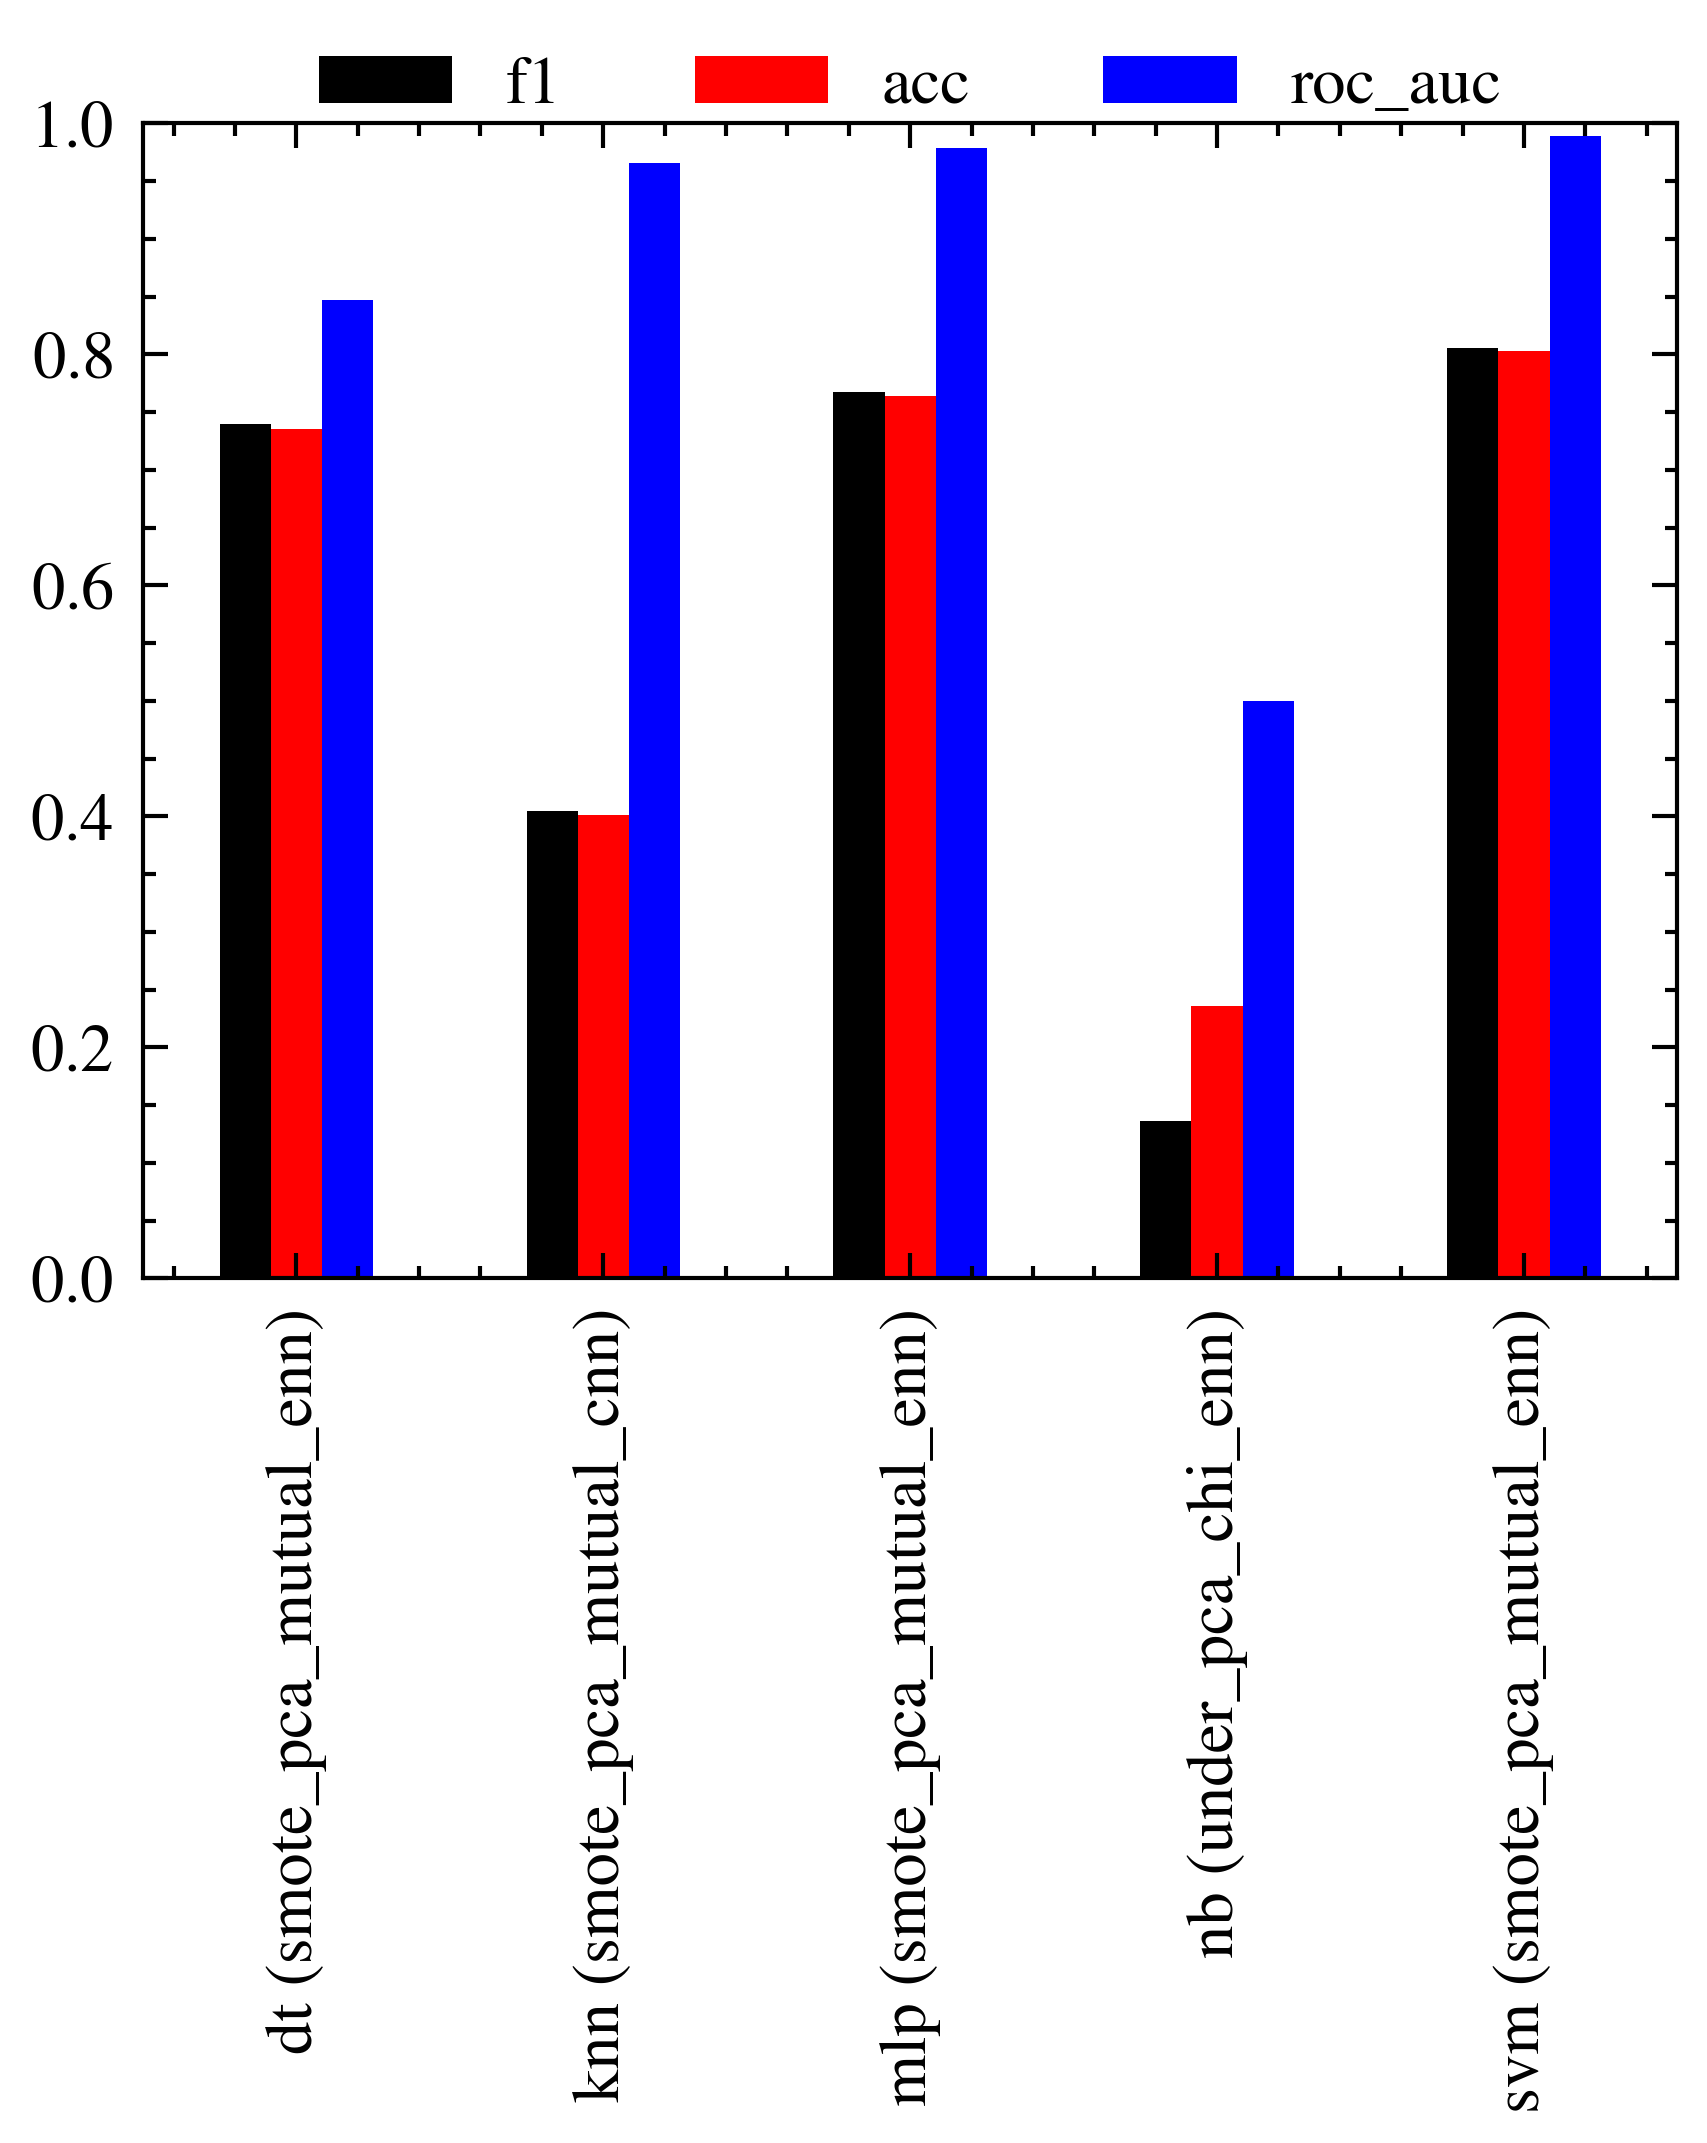

In [111]:
min_test['est_dataset_name'] = min_test['estimator_name'] + " (" + min_test['dataset_name'] + ")"

min_test.plot(kind='bar')#, figsize=(4,3))
plt.xticks(range(5), min_test['est_dataset_name'])
plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.11))
plt.ylim([0., 1.0])
#plt.yscale('log')
plt.plot()

In [86]:
max_idx = test_metrics_df.groupby(by='estimator_name')['f1'].idxmax()
max_test = test_metrics_df.iloc[max_idx]
max_test

,f1,acc,roc_auc,estimator_name,dataset_name
21,0.919043,0.929134,0.956768,dt,as_mutual_info
3,0.945949,0.951181,0.991621,knn,dr_pca
45,0.950077,0.957480,0.992522,mlp,bal_smote_dr_pca_as_chi2_ps_cnn
52,0.959264,0.965354,0.995699,nb,as_chi2
68,0.959049,0.965354,0.995782,svm,as_chi2


/tmp/ipykernel_685397/237554243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_test['est_dataset_name'] = max_test['estimator_name'] + " (" + max_test['dataset_name'] + ")"


[]

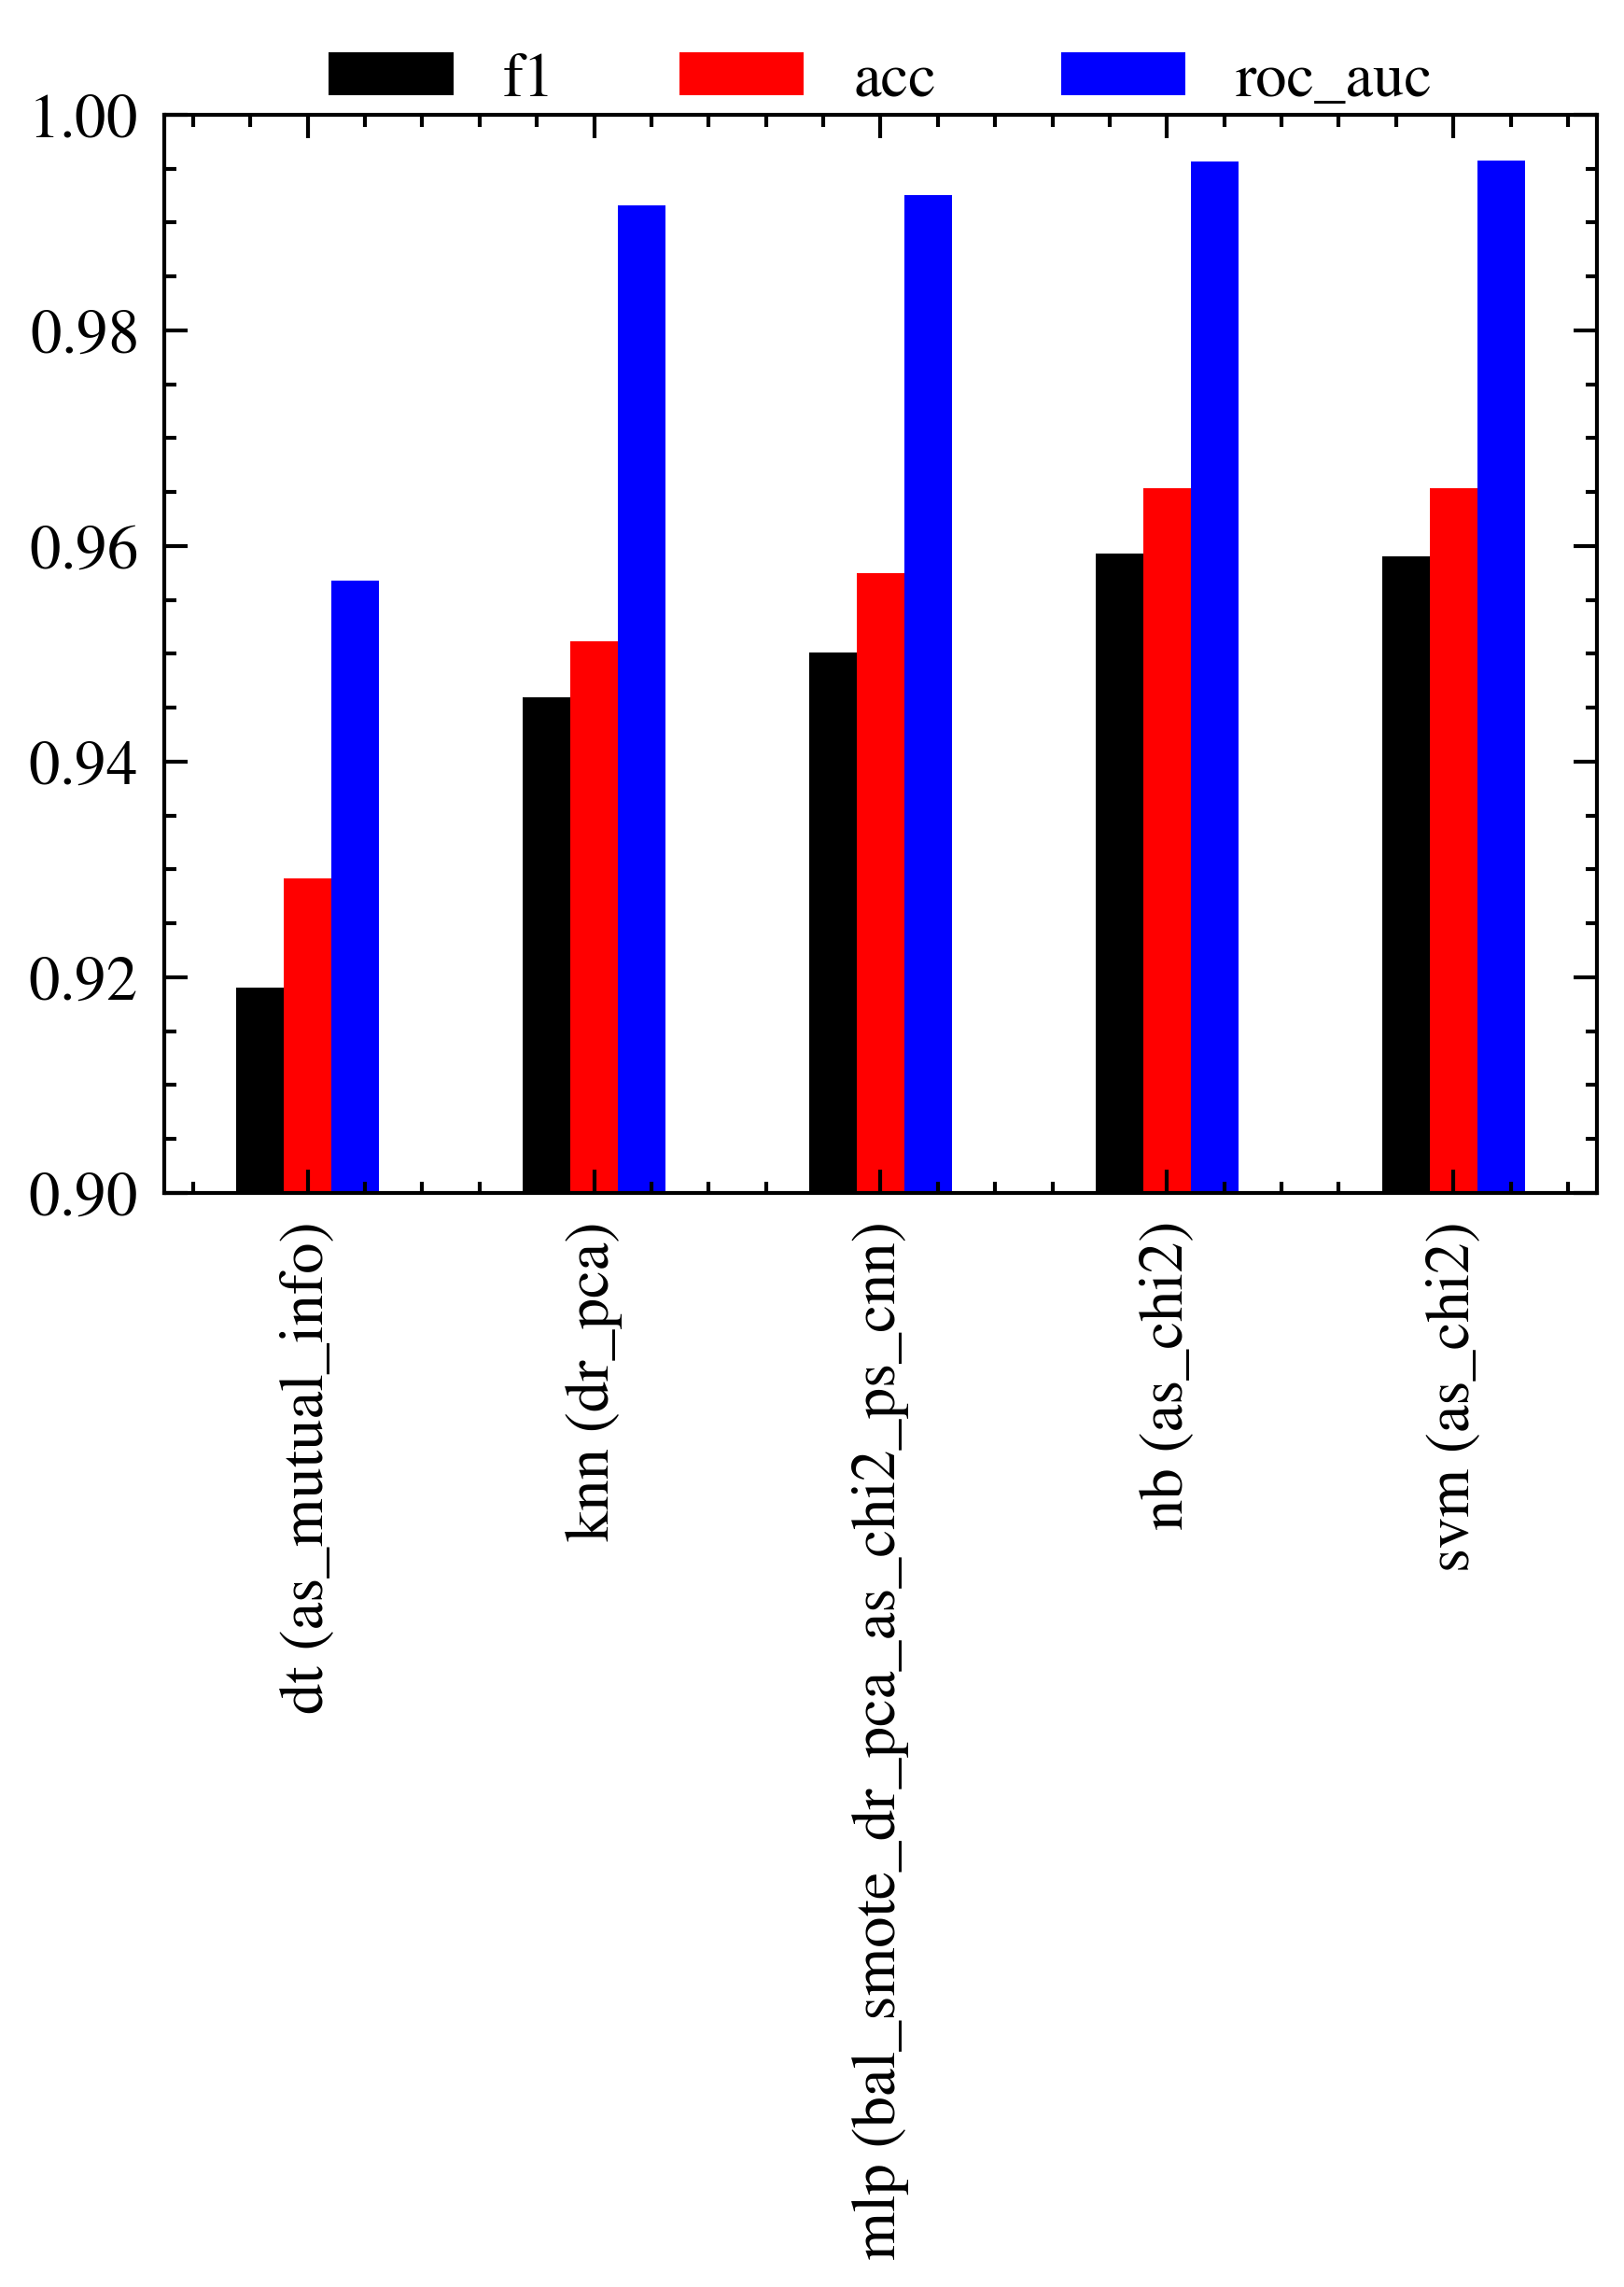

In [87]:
max_test['est_dataset_name'] = max_test['estimator_name'] + " (" + max_test['dataset_name'] + ")"

max_test.plot(kind='bar')#, figsize=(4,3))
plt.xticks(range(5), max_test['est_dataset_name'])
plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.11))
plt.ylim([0.9, 1.0])
#plt.yscale('log')
plt.plot()

In [116]:
np.array(best_estimators)[max_idx]

array([DecisionTreeClassifier(min_samples_leaf=3),
       KNeighborsClassifier(n_neighbors=126),
       MLPClassifier(activation='logistic', hidden_layer_sizes=36,
                     learning_rate_init=0.00018916515833716178, max_iter=500),
       BernoulliNB(alpha=7.974339106113763e-07),
       SVC(C=162393.57828066344, kernel='poly', probability=True)],
      dtype=object)

[]

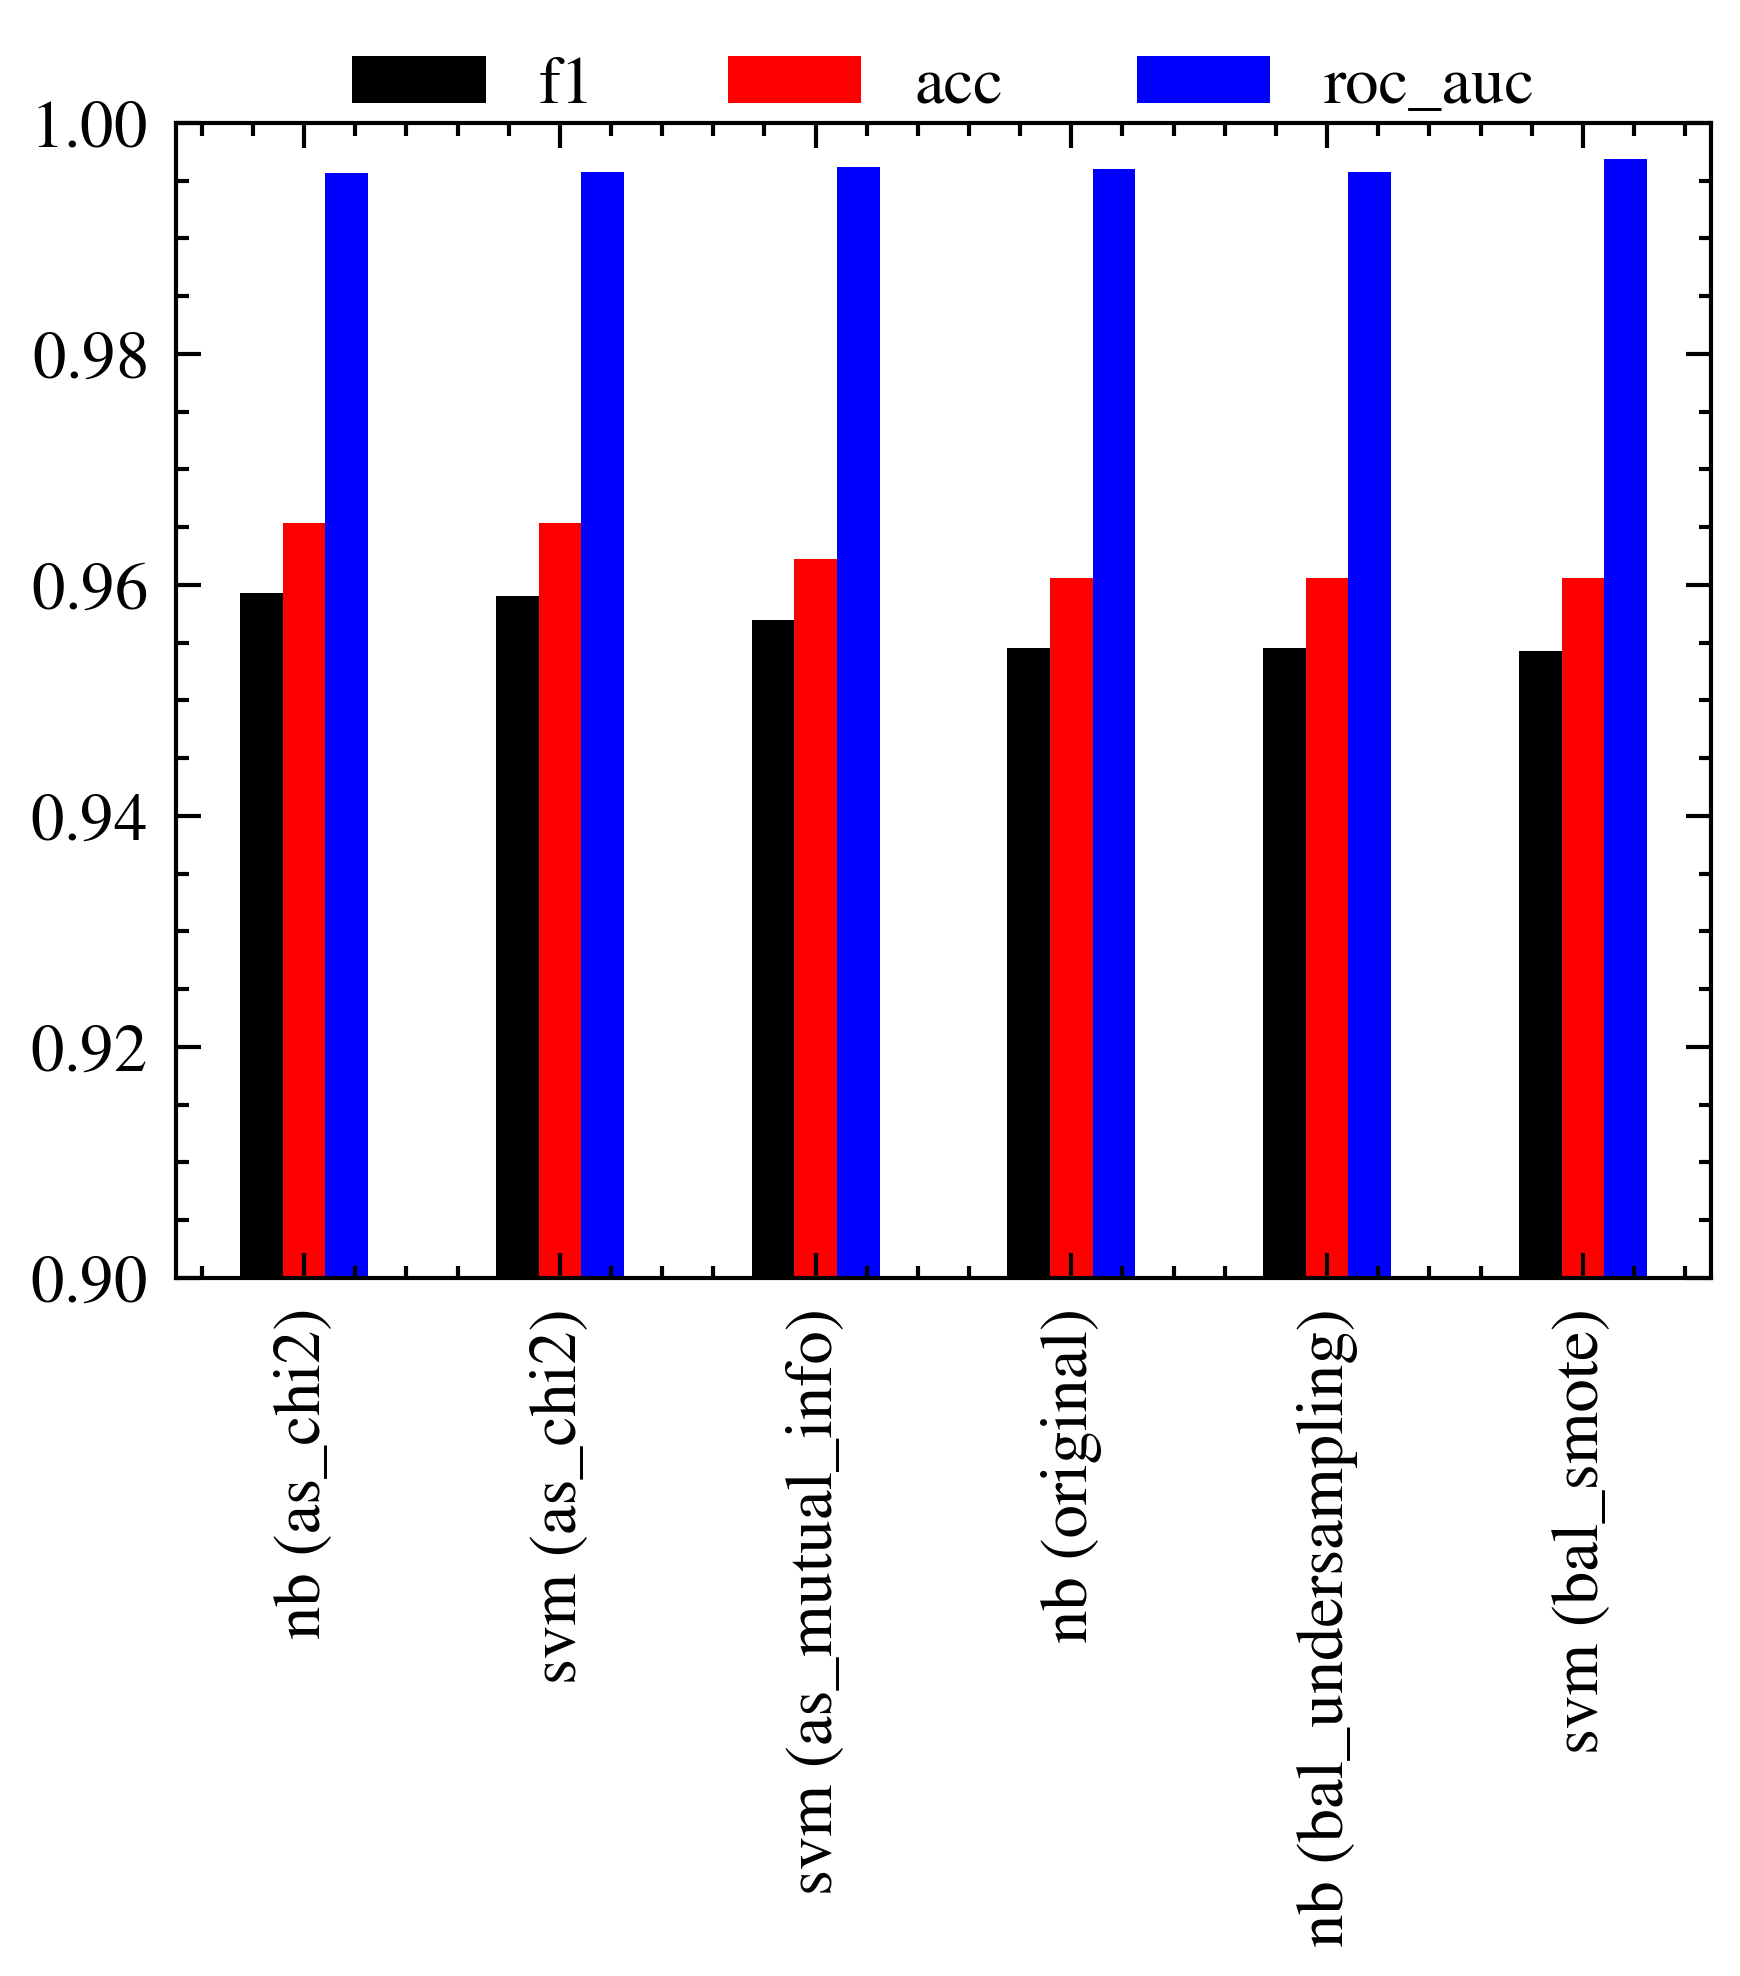

In [68]:
#métricas de validação (top 10 pares modelo-dataset)
top_n = 6
best_scored_models_test = test_metrics_df.nlargest(top_n, 'f1')
best_scored_models_test['est_dataset_name'] = best_scored_models_test['estimator_name'] + " (" + best_scored_models_test['dataset_name'] + ")"

best_scored_models_test.plot(kind='bar')#, figsize=(4,3))
plt.xticks(range(top_n), best_scored_models_test['est_dataset_name'])
plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.11))
plt.ylim([0.9, 1.0])
#plt.yscale('log')
plt.plot()

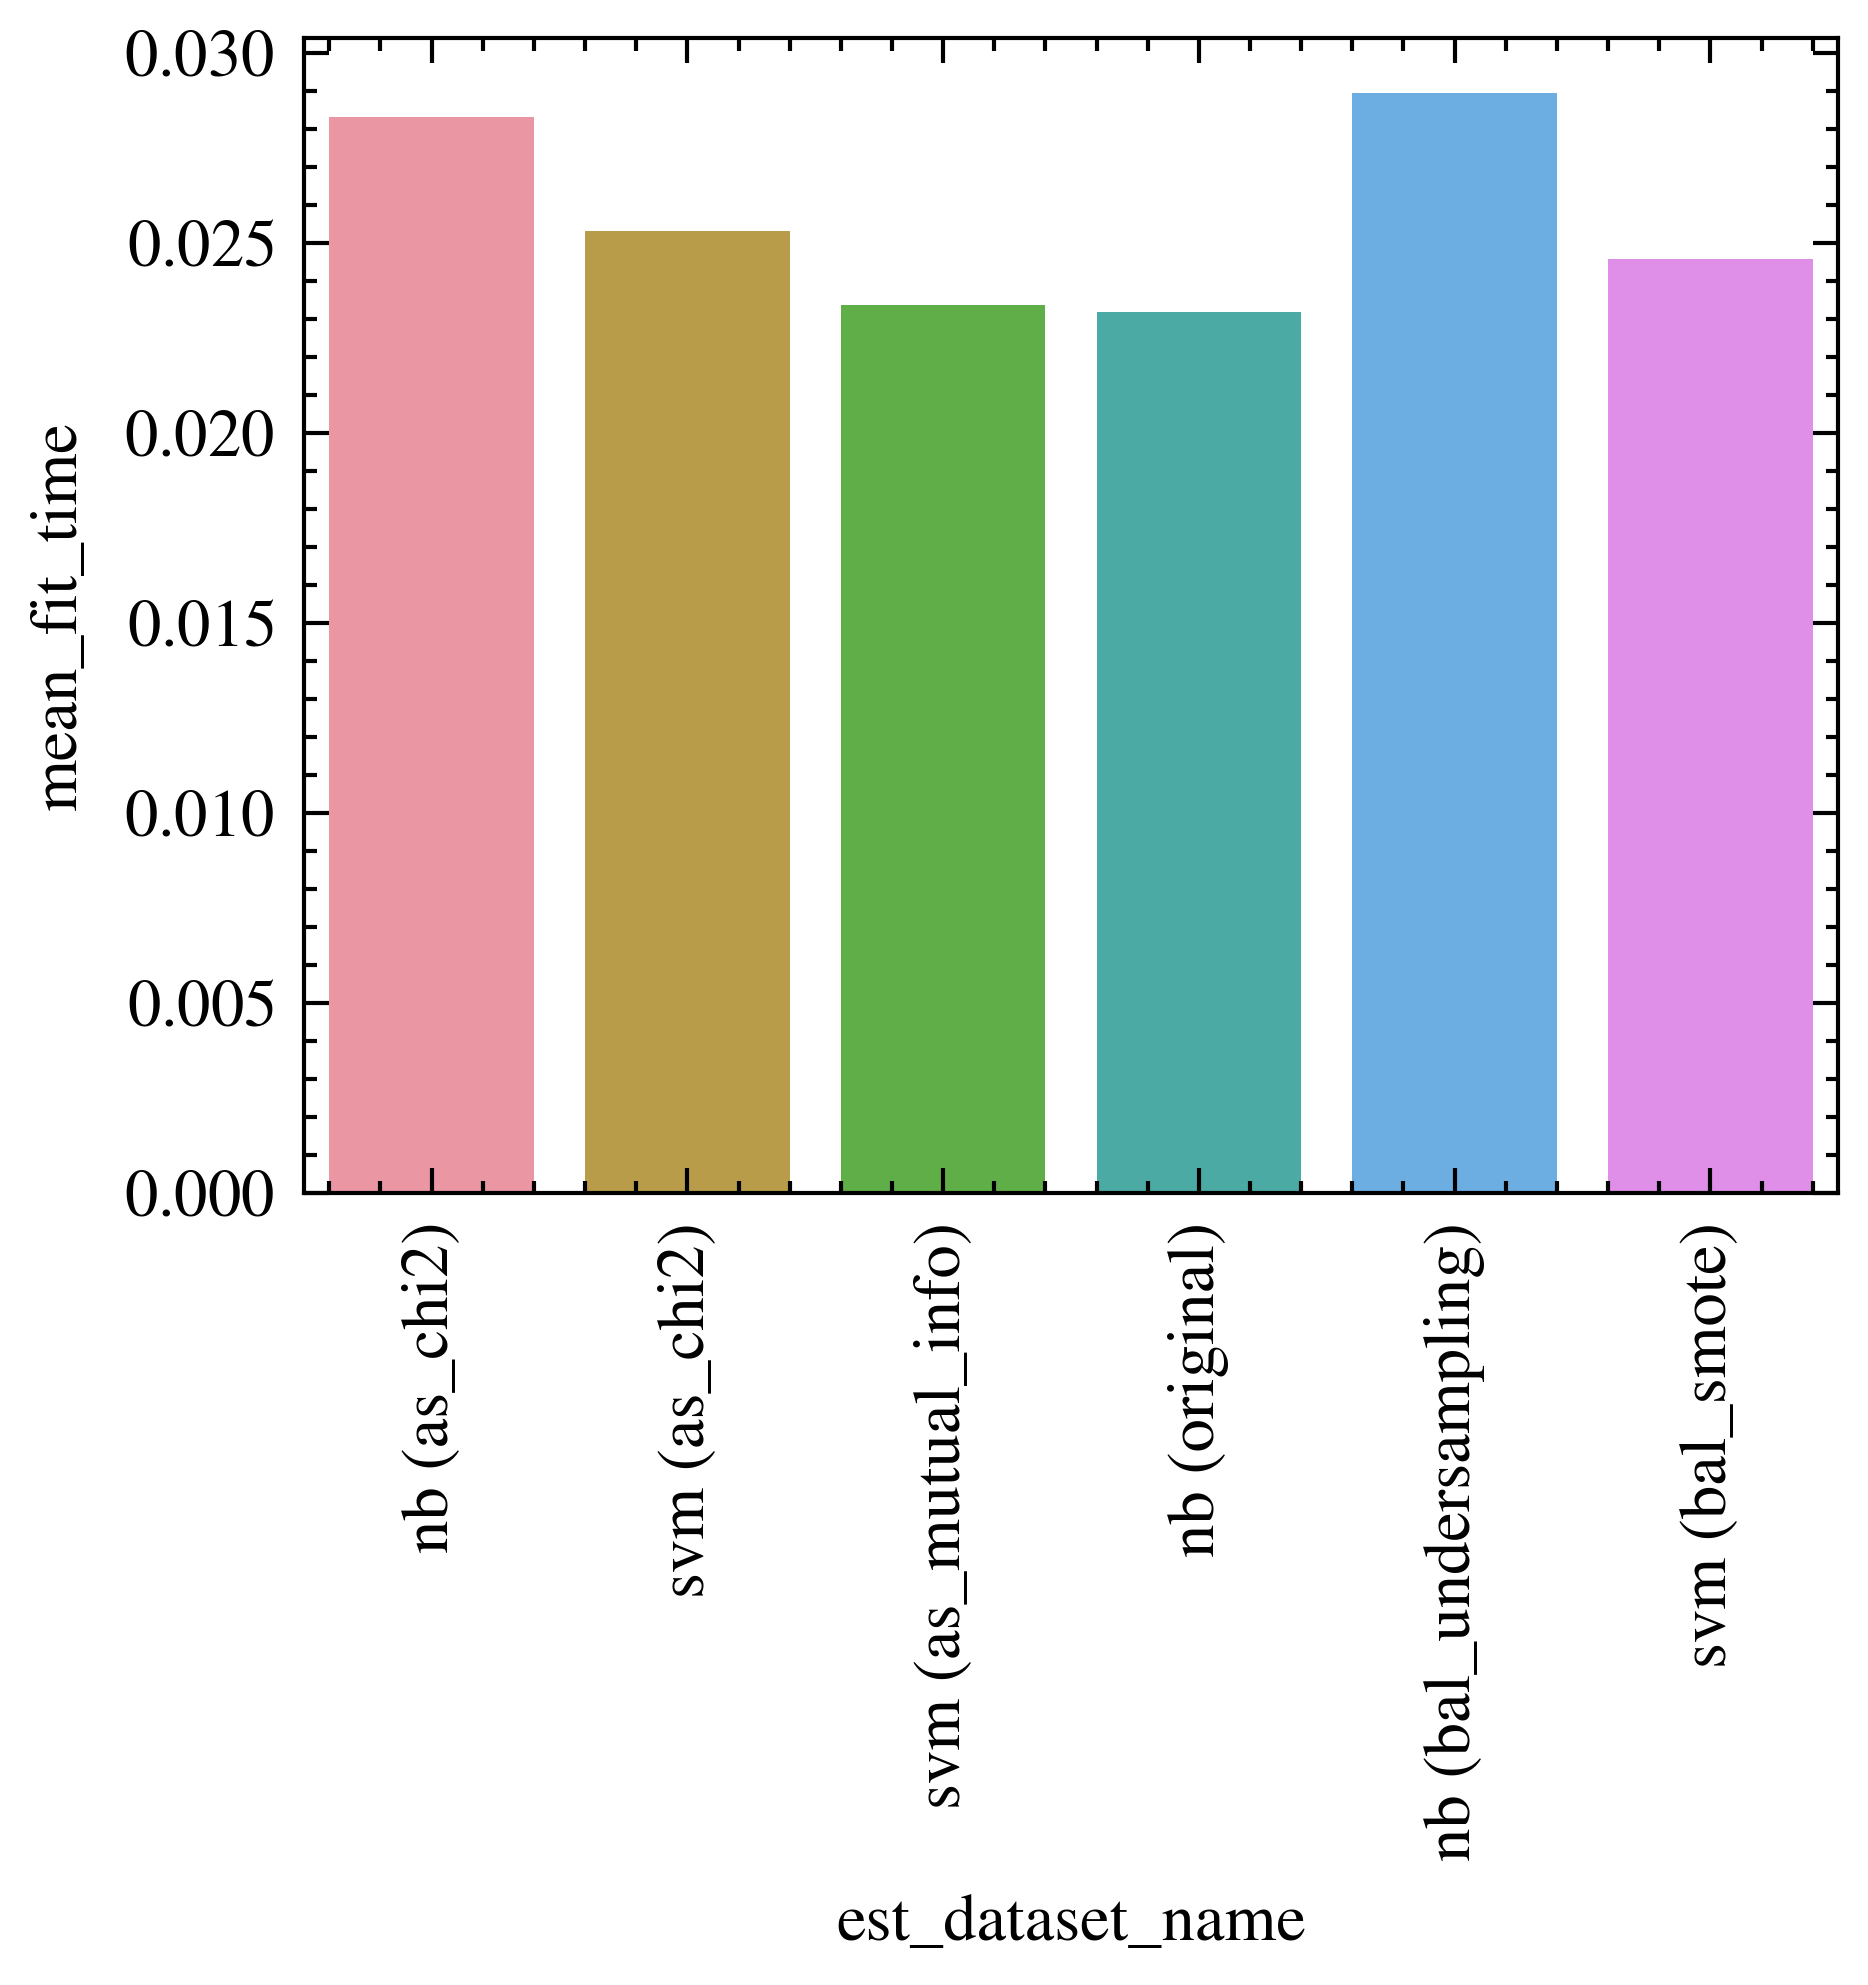

In [50]:
#Tempos médios para treinar os modelos acima

y_axis = train_metrics_df.iloc[best_scored_models_test.index, 0]
x_axis = best_scored_models_test['est_dataset_name']

sns.barplot(x=x_axis, y=y_axis)#, hue='estimator_name')
plt.xticks(rotation=90)
#plt.title("F1 Score x Accuracy (treino)")
plt.show()

Note que, entre os quatro melhores modelos (todos SVM), aqueles com pré-processamento chegam a levar menos da metade do tempo para treinarem.

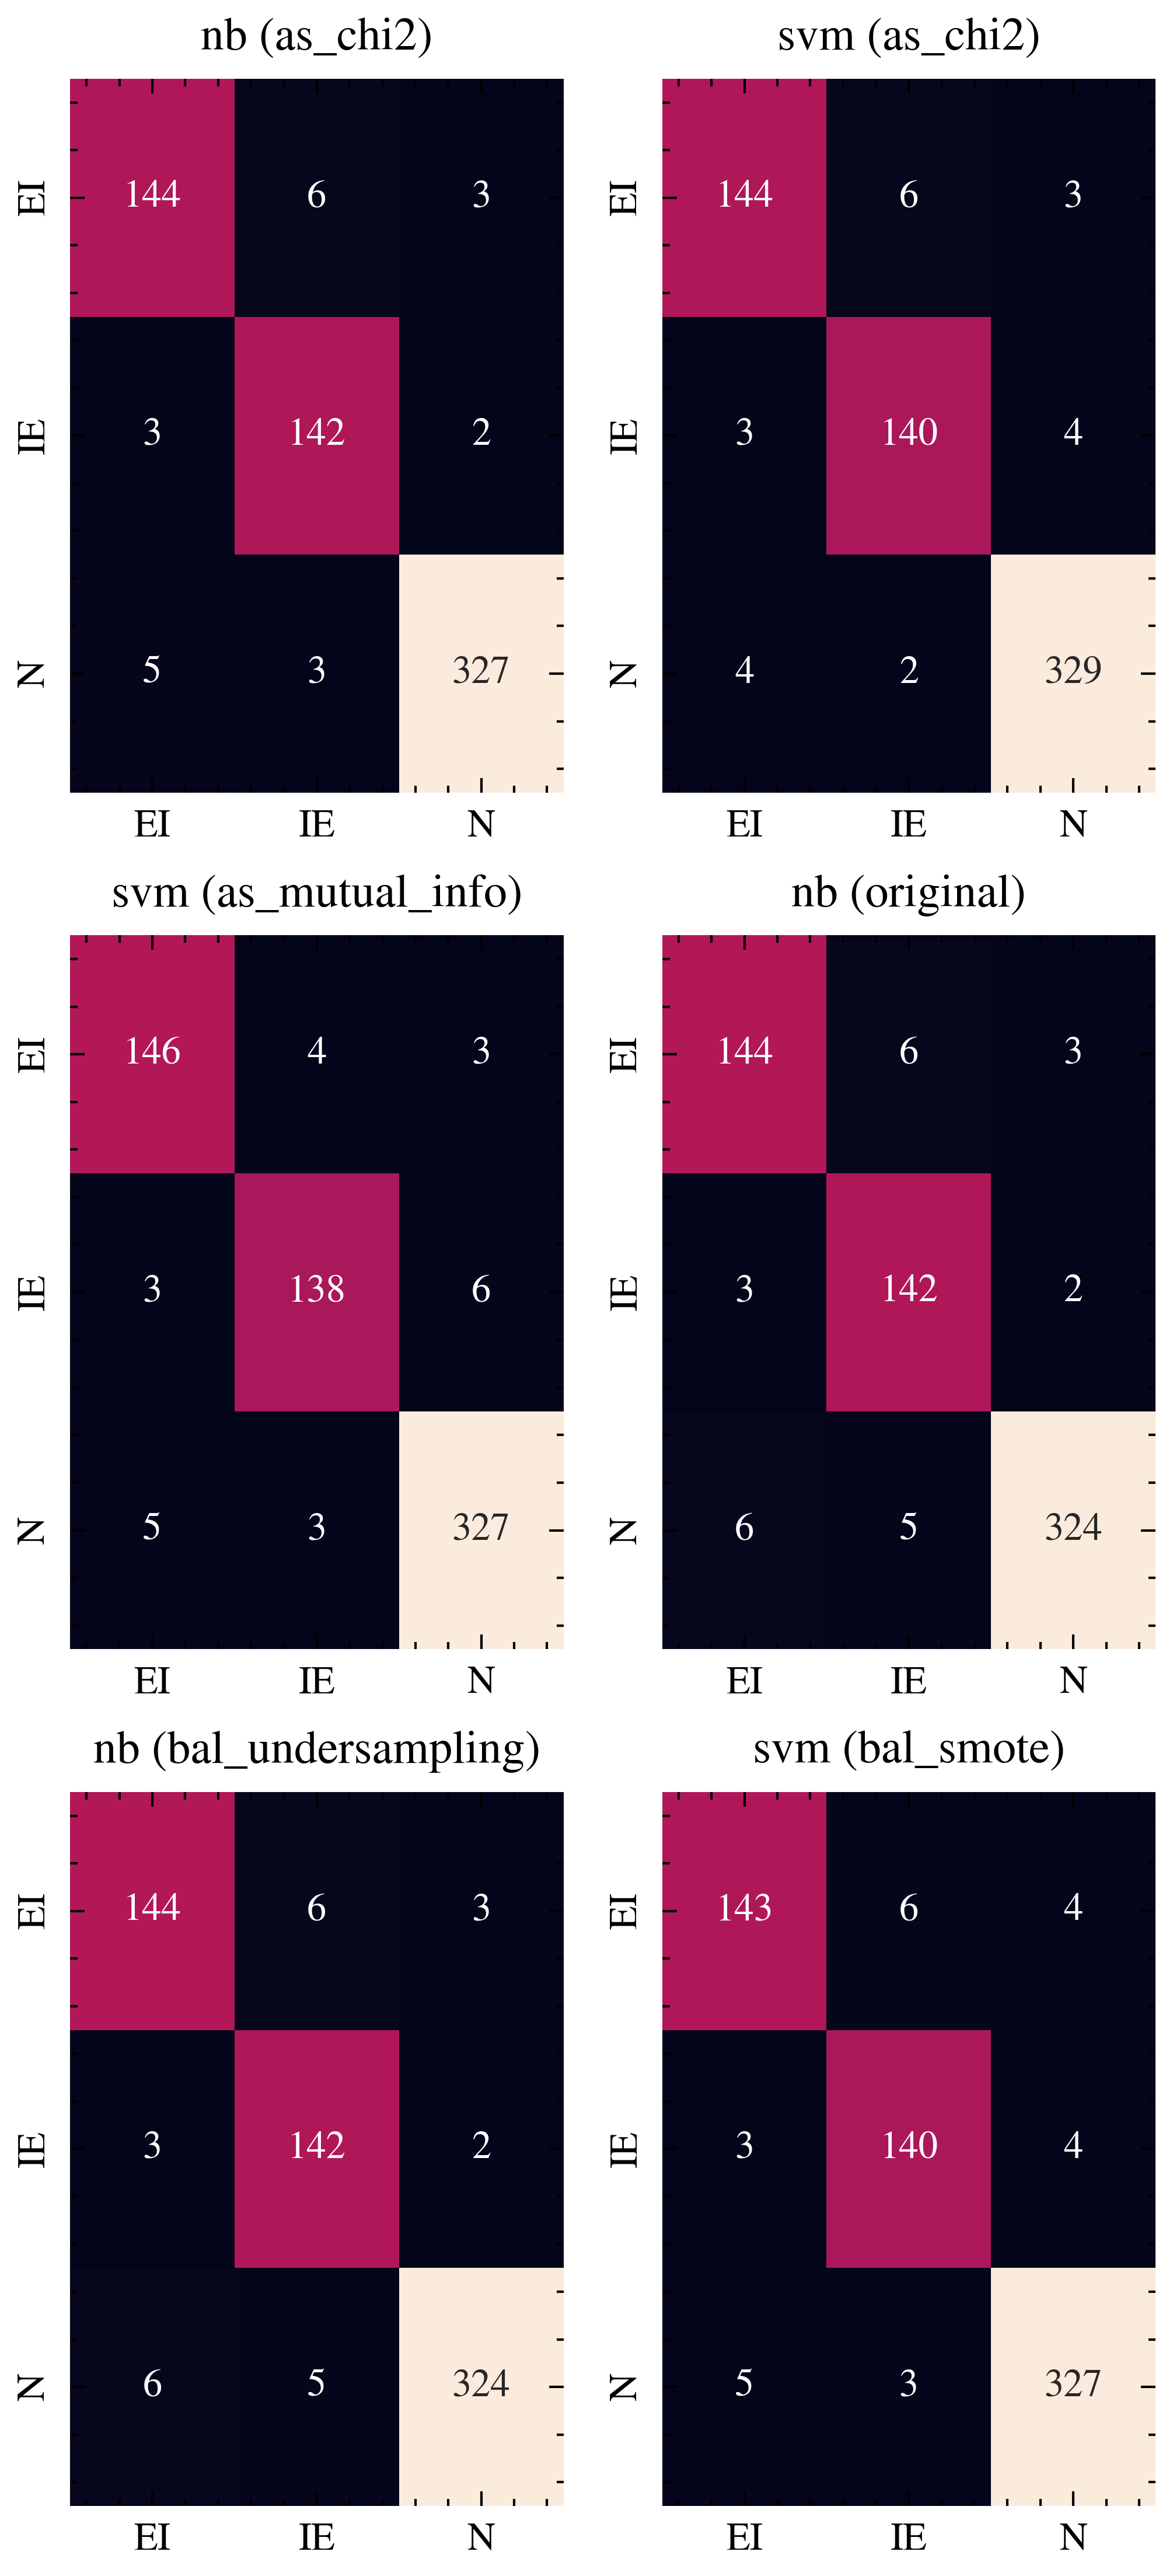

In [51]:
#TO DO: definir quantas confusion matrices colocaremos no artigo
#TO DO: corrigir isso aqui

labels = list(estimators.keys())
classes = ct.transformers_[1][1].categories_[0].tolist()
selected_conf_mats = np.array(conf_mats)[best_scored_models_test.index, :, :]


m = 3
n = 2
fig, ax = plt.subplots(m,n, figsize=(4,9))

k=0
for i, j in product(range(m), range(n)):
    sns.heatmap(selected_conf_mats[k, :, :], annot=True, fmt="", cbar=False, ax=ax[i, j])
    ax[i, j].set_xticklabels(classes)
    ax[i, j].set_yticklabels(classes)
    ax[i, j].set_title(best_scored_models_test['est_dataset_name'].iloc[k])
    k += 1